# Bloomberg data EDA

## Config

In [1]:
MIN_HIGH_REVENUE = 1000  # mln USD
BANKRUPTCY_DATA_VERSION = "4"
CONTROL_DATA_VERSION = "2m"  # None = does not include Control Data

# WARNING: if Control Data is included, it should be consistent with the minimum revenue threshold

## Setup

In [2]:
import datetime as dt
import itertools
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from loguru import logger
from pandas.api.types import is_string_dtype, is_numeric_dtype
from scipy.stats import norm

import shap
from lightgbm import LGBMRegressor, LGBMClassifier
from mlutil.eval import TimeSeriesSplit
from mlutil.model import GAM
# from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoLars
from sklearn.metrics import (
    log_loss, accuracy_score, 
    balanced_accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, precision_recall_curve, RocCurveDisplay,
    get_scorer_names
)
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

np.random.seed(42**3)

In [3]:
logger.remove()
logger.add(sys.stderr, format='{time} {level} {line}: {message}', level='DEBUG')

plt.style.use('seaborn-v0_8')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['font.family'] = 'monospace'

np.set_printoptions(edgeitems=30, linewidth=10000)
pd.options.display.max_rows = 200
pd.options.display.max_columns = 80
pd.options.display.max_colwidth = 100

In [4]:
def dht(df, n=2):
    display(pd.concat([df.head(n), df.tail(n)]))

In [5]:
def q25(x):
    return np.nanquantile(x, q=0.25)


def q75(x):
    return np.nanquantile(x, q=0.75)

## Data cleaning

### Load data

In [6]:
# --- All bankrupcy data
b_sheets = pd.read_excel(
    f"data/Bankruptcy Data v{BANKRUPTCY_DATA_VERSION}.xlsx", sheet_name=None, header=0, skiprows=1
)
b_sheet_names = list(b_sheets.keys())
print(b_sheet_names)

assert b_sheet_names[0] == "1. Date and Industry"

# Set a quarter (Q1 starts at January 1)
print("\n- compute Bankruptcy Quarter (Q1 starts at January 1)")
_df = b_sheets["1. Date and Industry"]
_df["Bankruptcy Date"] = pd.to_datetime(_df["Bankruptcy Date"], format=r"%m/%d/%Y")
_df["Bankruptcy Quarter"] = (
    _df["Bankruptcy Date"].dt.year.astype(str) 
    + "Q" + ((_df["Bankruptcy Date"].dt.month - 1) // 3 + 1).astype(str)
)
dht(_df)

['1. Date and Industry', 'Revenue', 'EBITDA', 'EBIT', 'Interest Expense', 'Net Income', 'Total Assets', 'ST Debt', 'LT Debt', 'Equity', 'Inventories', 'Acc Receivable', 'Acc Payable', 'Cash']

- compute Bankruptcy Quarter (Q1 starts at January 1)


,Name,Bankruptcy Date,Industry (Detailed),Assets (As of Bankruptcy date),Liabilities (As of Bankruptcy date),Ticker,BBID,Industry Level 1,BISC Code lvl1,Bankruptcy Quarter
0,VITAL PHARMACEUTICALS INC,2022-10-10,Sports & Energy Drinks,NaN,NaN,0311510Z US Equity,17394873,Consumer Staples,12,2022Q4
1,KABBAGE INC,2022-10-03,Commercial Finance,NaN,NaN,8172566Z US Equity,23987674,Financials,14,2022Q4
3059,BRADLEES INC,1995-06-23,Discount Stores,914.93M,783.56M,BLEEQ US Equity,100221,Consumer Staples,12,1995Q2
3060,MCCLATCHY CO LLC/THE,1900-07-01,Newspaper Publishers,946.50M,01.68B,1828306D US Equity,68830710,Communications,10,1900Q3


In [7]:
# --- Aux function to fix control quarter columns
def fix_control_quarters_columns(df: pd.DataFrame) -> None:
    old_qcols = [x for x in df.columns if (len(x.split(":")) == 3) and (x[-2] == "Q")]
    new_qcols = [x[-2:] + " " + x[-5:-3] for x in old_qcols]
    assert all(len(x) == 5 for x in new_qcols)
    df.rename(columns=dict(zip(old_qcols, new_qcols)), inplace=True)
    for col in new_qcols:
        df[col] /= 1000000
    

_df = pd.DataFrame({
    "Ticker": ["ADD", "BDD"], 
    "Q3 21": [0, 1.3], 
    "Revenue:2021:Q4": [1200000, 1340000],
})
_df_expected = pd.DataFrame({
    "Ticker": ["ADD", "BDD"], 
    "Q3 21": [0, 1.3], 
    "Q4 21": [1.2, 1.34],
})
fix_control_quarters_columns(_df)
pd.testing.assert_frame_equal(_df, _df_expected)

In [8]:
# --- Clean control data (make consistent with bankruptcy data) ---

if CONTROL_DATA_VERSION is not None:
    c_sheets = pd.read_excel(
        f"data/Control Data v{CONTROL_DATA_VERSION}.xlsx", 
        sheet_name=None, 
        header=0, 
        skiprows=[0, 1, 3],
    )
    c_sheet_names = list(c_sheets.keys())
    print(c_sheet_names)
    
    # Rename sheets
    c_sheets["1. Date and Industry"] = c_sheets.pop("1. Industry")
    c_sheet_names = list(c_sheets.keys())
    print(c_sheet_names)
    assert set(c_sheet_names) == set(b_sheet_names)

    # Fix master df 
    _df = c_sheets["1. Date and Industry"]
    _df.rename(columns={
        "Short Name": "Name",
        "BICS L1 Sect Nm": "Industry Level 1",
        "BICS L1 Sect Cde": "BISC Code lvl1",
    }, inplace=True)
    # _df["Bankruptcy Date"] = "01/01/2050"

    # Fix metrics dfs
    assert c_sheet_names[-1] == "1. Date and Industry"
    for sname in c_sheet_names[:-1]:
        _df = c_sheets[sname]
        _df.rename(columns={"Short Name": "Name"}, inplace=True)
        fix_control_quarters_columns(_df)
        assert all(x.startswith("Q") for x in _df.columns[2:])
        for c in _df.columns[2:]:
            if not is_numeric_dtype(_df[c].dtype):
                print(f"WARNING: {sname} {c} has type {_df[c].dtype}")
                _df[c] = pd.to_numeric(_df[c], errors="coerce")
                
    # Concatenate bankruptcy and controlled data
    sheets = {}
    for sname in b_sheet_names:
        print(f"concatenate {sname}: {len(b_sheets[sname])} + {len(c_sheets[sname])}")
        sheets[sname] = pd.concat((b_sheets[sname], c_sheets[sname]), ignore_index=True)
        
else:
    sheets = b_sheets
    
sheet_names = b_sheet_names
dht(sheets["1. Date and Industry"])
dht(sheets["Revenue"])
dht(sheets["Cash"])

for sname in sheet_names[1:]:
    _df = sheets[sname]
    assert all(x.startswith("Q") for x in _df.columns[3:])
    for c in _df.columns[3:]:
        if not is_numeric_dtype(_df[c].dtype):
            raise TypeError(f"{sname} {c} has type {_df[c].dtype}")

['1. Industry', 'Revenue', 'EBITDA', 'EBIT', 'Interest Expense', 'Net Income', 'Total Assets', 'ST Debt', 'LT Debt', 'Equity', 'Inventories', 'Acc Receivable', 'Acc Payable', 'Cash']
['Revenue', 'EBITDA', 'EBIT', 'Interest Expense', 'Net Income', 'Total Assets', 'ST Debt', 'LT Debt', 'Equity', 'Inventories', 'Acc Receivable', 'Acc Payable', 'Cash', '1. Date and Industry']
concatenate 1. Date and Industry: 3061 + 947
concatenate Revenue: 767 + 948
concatenate EBITDA: 767 + 948
concatenate EBIT: 3061 + 948
concatenate Interest Expense: 3061 + 947
concatenate Net Income: 3061 + 948
concatenate Total Assets: 3061 + 948
concatenate ST Debt: 3061 + 947
concatenate LT Debt: 3061 + 947
concatenate Equity: 3061 + 947
concatenate Inventories: 3061 + 947
concatenate Acc Receivable: 3061 + 947
concatenate Acc Payable: 3061 + 947
concatenate Cash: 3061 + 947


,Name,Bankruptcy Date,Industry (Detailed),Assets (As of Bankruptcy date),Liabilities (As of Bankruptcy date),Ticker,BBID,Industry Level 1,BISC Code lvl1,Bankruptcy Quarter
0,VITAL PHARMACEUTICALS INC,2022-10-10,Sports & Energy Drinks,NaN,NaN,0311510Z US Equity,17394873.0,Consumer Staples,12,2022Q4
1,KABBAGE INC,2022-10-03,Commercial Finance,NaN,NaN,8172566Z US Equity,23987674.0,Financials,14,2022Q4
4006,CME GROUP INC,NaT,NaN,NaN,NaN,CME US Equity,NaN,Financials,14,NaN
4007,HYATT HOTELS-A,NaT,NaN,NaN,NaN,H US Equity,NaN,Consumer Discretionary,11,NaN


,Name,Ticker,BCY year,Q4 21,Q3 21,Q2 21,Q1 21,Q4 20,Q3 20,Q2 20,Q1 20,Q4 19,Q3 19,Q2 19,Q1 19,Q4 18,Q3 18,Q2 18,Q1 18,Q4 17,Q3 17,Q2 17,Q1 17,Q4 16,Q3 16,Q2 16,Q1 16,Q4 15,Q3 15,Q2 15,Q1 15,Q4 14,Q3 14,Q2 14,Q1 14,Q4 13,Q3 13,Q2 13,Q1 13,Q4 12,...,Q2 07,Q1 07,Q4 06,Q3 06,Q2 06,Q1 06,Q4 05,Q3 05,Q2 05,Q1 05,Q4 04,Q3 04,Q2 04,Q1 04,Q4 03,Q3 03,Q2 03,Q1 03,Q4 02,Q3 02,Q2 02,Q1 02,Q4 01,Q3 01,Q2 01,Q1 01,Q4 00,Q3 00,Q2 00,Q1 00,Q4 99,Q3 99,Q2 99,Q1 99,Q4 98,Q3 98,Q2 98,Q1 98,Q2 22,Q1 22
0,CLARUS THERAPEUTICS HOLDINGS,CRXT US Equity,2022.0,4.562000,4.286000,0.00,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENDO INTERNATIONAL PLC,ENDPQ US Equity,2022.0,789.429000,772.028000,713.83,717.919000,760.221000,634.860000,687.588000,820.405000,764.800000,729.426000,699.727000,720.411000,786.389000,745.466,714.696000,700.527000,768.640000,786.887,875.731000,1037.600000,1241.513000,884.335000,920.887000,963.539000,1073.697000,745.727000,735.166,714.128000,662.877000,654.116,592.848,470.842,584.946000,661.319,712.148000,658.494,749.82,...,257.147,254.409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1713,CME GROUP INC,CME US Equity,NaN,1147.299968,1109.900032,1179.20,1253.299968,1098.499968,1080.700032,1182.300032,1522.099968,1138.400000,1277.299968,1272.700032,1179.600000,1236.600064,904.200,1059.600000,1108.999936,900.000000,890.800,924.600000,929.299968,912.899968,841.699968,906.400000,934.200000,813.800000,850.300032,820.000,842.700032,841.100032,762.400,731.600,777.400,687.000000,714.600,816.099968,718.600,1000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1483.000064,1279.000064
1714,HYATT HOTELS-A,H US Equity,NaN,1076.000000,851.000000,663.00,438.000000,424.000000,399.000000,250.000000,993.000000,1275.000064,1215.000064,1288.999936,1240.999936,1138.000000,1074.000,1132.999936,1108.999936,1116.999936,1070.000,1148.999936,1126.000000,923.000000,1088.000000,1164.999936,1088.999936,1108.999936,1053.000000,1112.000,1054.000000,1079.000064,1104.000,1158.000,1074.000,1091.000064,1026.000,1092.000000,975.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Name,Ticker,BCY year,Q4 21,Q3 21,Q2 21,Q1 21,Q4 20,Q3 20,Q2 20,Q1 20,Q4 19,Q3 19,Q2 19,Q1 19,Q4 18,Q3 18,Q2 18,Q1 18,Q4 17,Q3 17,Q2 17,Q1 17,Q4 16,Q3 16,Q2 16,Q1 16,Q4 15,Q3 15,Q2 15,Q1 15,Q4 14,Q3 14,Q2 14,Q1 14,Q4 13,Q3 13,Q2 13,Q1 13,Q4 12,...,Q2 07,Q1 07,Q4 06,Q3 06,Q2 06,Q1 06,Q4 05,Q3 05,Q2 05,Q1 05,Q4 04,Q3 04,Q2 04,Q1 04,Q4 03,Q3 03,Q2 03,Q1 03,Q4 02,Q3 02,Q2 02,Q1 02,Q4 01,Q3 01,Q2 01,Q1 01,Q4 00,Q3 00,Q2 00,Q1 00,Q4 99,Q3 99,Q2 99,Q1 99,Q4 98,Q3 98,Q2 98,Q1 98,Q2 22,Q1 22
0,CLARUS THERAPEUTICS HOLDINGS,CRXT US Equity,2022.0,26.415000,21.953000,0.224535,0.408195,0.655371,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENDO INTERNATIONAL PLC,ENDPQ US Equity,2022.0,1507.196000,1568.665000,1545.172000,1427.775000,1213.437000,1679.738000,1780.087000,1531.538000,1454.531000,1526.250000,1446.949000,981.739,1149.113000,1118.885000,1098.788000,980.412,986.605,738.393000,616.534000,617.589000,517.250000,561.577000,667.822000,221.968,272.348000,836.111000,2529.735000,377.461,405.696000,708.529000,1427.244000,1041.280000,526.597000,594.085000,505.608,340.517000,529.689,...,445.829,730.857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4006,CME GROUP INC,CME US Equity,NaN,2834.899968,1459.399936,1080.999936,936.400000,1633.200000,1332.099968,1405.400064,851.699968,1551.399936,1210.099968,937.699968,997.400,1374.499968,1406.300032,1098.899968,784.600,1903.600,1631.100032,1362.300032,1287.800064,1868.600064,1420.499968,1161.100032,1146.000,1692.600064,1434.300032,1151.000064,1694.800,1366.099968,1087.900032,1037.299968,1053.699968,2469.700096,2064.999936,1968.000,1843.399936,1604.700,...,NaN,1139.793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1879.500032,2045.699968
4007,HYATT HOTELS-A,H US Equity,NaN,960.000000,2417.999872,1144.000000,1078.000000,1207.000064,1778.000000,1438.000000,1194.000000,893.000000,660.000000,515.000000,547.000,570.000000,1014.000000,628.000000,1160.000,503.000,383.000000,400.000000,374.000000,482.000000,544.000000,642.000000,771.000,457.000000,569.000000,644.000000,563.000,685.000000,263.000000,553.000000,765.000000,454.000000,774.000000,718.000,330.000000,413.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1428.000000,1023.000000


### Company, Name, Ticker, Industry, Bankruptcy date

In [9]:
def unify_bloombergs_units(ss: pd.Series) -> pd.Series:
    assert is_string_dtype(ss.dtype)
    numbers = ss.str[:-1].astype(float)
    units = ss.str[-1:]
    unified_numbers = numbers * units.map({"M": 1., "B": 1000., "k": 0.001}).astype(float)
    return unified_numbers


def keep_us_only(df: pd.DataFrame) -> pd.DataFrame:
    return df.loc[df["Ticker"].str.endswith(" US Equity")].reset_index(drop=True)


def shorten_ticker(tickers: pd.Series) -> pd.Series:
    assert tickers.str.endswith(" Equity").all()
    short_tickers = tickers.str.split(n=1).str[0]
    assert short_tickers.nunique() == tickers.nunique()
    return short_tickers


def encode_quarter(quarters: pd.Series) -> pd.Series:
    assert is_string_dtype(quarters.dtype)
    assert (quarters.isnull() | (quarters.str.len() == 6)).all()
    years = quarters.str[:4].astype(pd.Int64Dtype())
    assert (1970 <= years).all() 
    assert (2050 >= years).all() 
    qs = quarters.str[5].astype(pd.Int64Dtype())
    qs.isin(set([1, 2, 3, 4])) 
    qcodes = years * 4 + (qs - 1)
    assert qcodes.nunique() == quarters.nunique()
    return qcodes


def decode_quarter(qcodes: pd.Series) -> pd.Series:
    assert (7800 < qcodes).all()
    assert (8200 > qcodes).all()
    years = qcodes // 4
    qs = qcodes % 4 + 1
    quarters = years.astype(str) + "Q" + qs.astype(str)
    assert qcodes.nunique() == quarters.nunique()
    return quarters

In [10]:
pd.testing.assert_series_equal(
    unify_bloombergs_units(pd.Series(["13.4M", "1.4B", "90.3k"])),
    pd.Series([13.4, 1400., 0.0903])
)

pd.testing.assert_series_equal(
    shorten_ticker(pd.Series(["0311510Z US Equity", "BLEEQ CN Equity"])),
    pd.Series(["0311510Z", "BLEEQ"])
)

pd.testing.assert_series_equal(
    encode_quarter(pd.Series(["2020Q1", "2021Q1", "2021Q2"])),
    pd.Series([8080, 8084, 8085], dtype=pd.Int64Dtype())
)

pd.testing.assert_series_equal(
    encode_quarter(pd.Series(["2020Q1", "2021Q1", pd.NA])),
    pd.Series([8080, 8084, pd.NA], dtype=pd.Int64Dtype())
)

pd.testing.assert_series_equal(
    decode_quarter(pd.Series([8080, 8084, 8085])),
    pd.Series(["2020Q1", "2021Q1", "2021Q2"])
)

In [11]:
# --- Clean the master sheet (Ticker + Industry + Bankruptcy data)

_df = sheets["1. Date and Industry"]
dht(_df)
print(f"n records = {len(_df)}")

# Remove non-US companies
print("\n- keep US companies only")
_df = keep_us_only(_df)
print(f"n records = {len(_df)}")

# Short ticker name
print("\n- create Short Ticker")
_df["Short Ticker"] = shorten_ticker(_df["Ticker"])

# Uniform format for Assets and Liabilities
print("\n- convert assets and liabilities to M USD")
print(_df["Assets (As of Bankruptcy date)"].str[-1:].value_counts(dropna=False))
print(_df["Liabilities (As of Bankruptcy date)"].str[-1:].value_counts(dropna=False))
_df["Assets (As of Bankruptcy date)"] = unify_bloombergs_units(_df["Assets (As of Bankruptcy date)"])
_df["Liabilities (As of Bankruptcy date)"] = unify_bloombergs_units(_df["Liabilities (As of Bankruptcy date)"])

master_df = _df
dht(master_df)

,Name,Bankruptcy Date,Industry (Detailed),Assets (As of Bankruptcy date),Liabilities (As of Bankruptcy date),Ticker,BBID,Industry Level 1,BISC Code lvl1,Bankruptcy Quarter
0,VITAL PHARMACEUTICALS INC,2022-10-10,Sports & Energy Drinks,NaN,NaN,0311510Z US Equity,17394873.0,Consumer Staples,12,2022Q4
1,KABBAGE INC,2022-10-03,Commercial Finance,NaN,NaN,8172566Z US Equity,23987674.0,Financials,14,2022Q4
4006,CME GROUP INC,NaT,NaN,NaN,NaN,CME US Equity,NaN,Financials,14,NaN
4007,HYATT HOTELS-A,NaT,NaN,NaN,NaN,H US Equity,NaN,Consumer Discretionary,11,NaN


n records = 4008

- keep US companies only
n records = 3922

- create Short Ticker

- convert assets and liabilities to M USD
M      1999
NaN    1419
B       391
k       113
Name: Assets (As of Bankruptcy date), dtype: int64
M      2219
NaN    1205
B       488
k        10
Name: Liabilities (As of Bankruptcy date), dtype: int64


,Name,Bankruptcy Date,Industry (Detailed),Assets (As of Bankruptcy date),Liabilities (As of Bankruptcy date),Ticker,BBID,Industry Level 1,BISC Code lvl1,Bankruptcy Quarter,Short Ticker
0,VITAL PHARMACEUTICALS INC,2022-10-10,Sports & Energy Drinks,NaN,NaN,0311510Z US Equity,17394873.0,Consumer Staples,12,2022Q4,0311510Z
1,KABBAGE INC,2022-10-03,Commercial Finance,NaN,NaN,8172566Z US Equity,23987674.0,Financials,14,2022Q4,8172566Z
3920,CME GROUP INC,NaT,NaN,NaN,NaN,CME US Equity,NaN,Financials,14,NaN,CME
3921,HYATT HOTELS-A,NaT,NaN,NaN,NaN,H US Equity,NaN,Consumer Discretionary,11,NaN,H


In [12]:
# Industries
master_df["Industry Level 1"].value_counts()

Consumer Discretionary    886
Industrials               557
Energy                    355
Financials                338
Health Care               311
Communications            296
Materials                 287
Technology                269
Real Estate               266
Consumer Staples          240
Utilities                 104
Unclassifiable              1
Government                  1
Name: Industry Level 1, dtype: int64

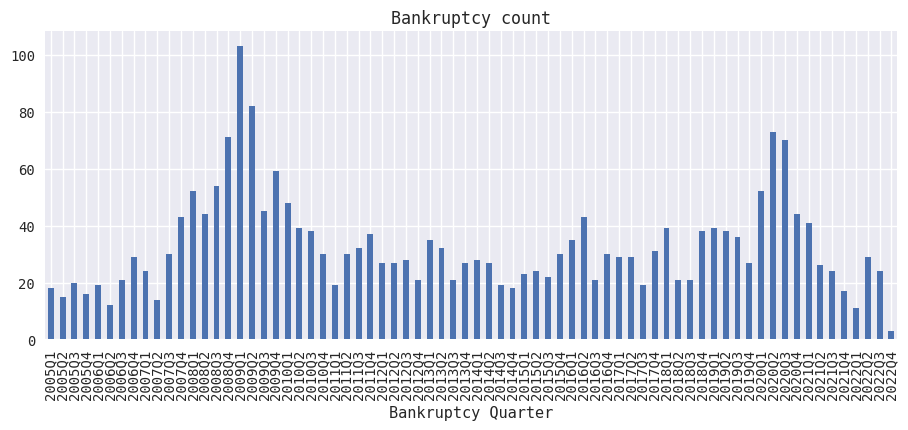

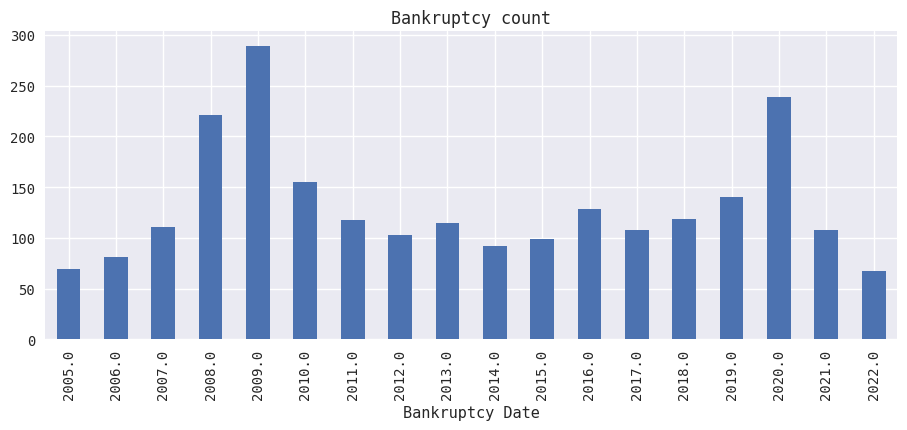

In [13]:
# --- Plot bankruptcy counts ---

plt.figure()
(
    master_df.loc[master_df["Bankruptcy Quarter"] >= "2005"]
    .groupby("Bankruptcy Quarter")["Bankruptcy Quarter"].count()
    .plot(kind="bar", figsize=(11, 4), title="Bankruptcy count")
)
plt.figure()
(
    master_df.loc[master_df["Bankruptcy Quarter"] >= "2005"]
    .groupby(master_df["Bankruptcy Date"].dt.year)["Bankruptcy Date"].count()
    .plot(kind="bar", figsize=(11, 4), title="Bankruptcy count")
)
_ = _

In [14]:
# --- Example of a duplicate (two bunkruptcies of one company)
master_df.loc[master_df["Ticker"] == "HCR US Equity"]

,Name,Bankruptcy Date,Industry (Detailed),Assets (As of Bankruptcy date),Liabilities (As of Bankruptcy date),Ticker,BBID,Industry Level 1,BISC Code lvl1,Bankruptcy Quarter,Short Ticker
281,HI-CRUSH INC,2020-07-12,Oilfield Services & Equipment,953.08,699.14,HCR US Equity,32051410.0,Energy,13,2020Q3,HCR
652,MANOR CARE INC,2018-03-04,Oilfield Services & Equipment,4260.00,7120.00,HCR US Equity,100719.0,Energy,13,2018Q1,HCR


In [15]:
# --- Remove companies with multiple bankrupcies (for simplicity) ---

print(f'duplicates: {master_df["Ticker"].duplicated(keep=False).sum()} / {len(master_df)}')
print(f'duplicates: {master_df["Short Ticker"].duplicated(keep=False).sum()} / {len(master_df)}')

print("\ndrop tickers with duplicates")
all_valid_tickers = set(master_df["Short Ticker"].drop_duplicates(keep=False))
print(f"n tickers = {len(all_valid_tickers)}")

duplicates: 128 / 3922
duplicates: 128 / 3922

drop tickers with duplicates
n tickers = 3794


### Filter tickets by revenue

count      1645.000000
mean       2088.216538
std        5959.951551
min           0.000000
25%         112.448384
50%         568.624821
75%        1612.366270
max      115878.225793
Name: Mean Revenue, dtype: float64


,Name,Ticker,BCY year,Q4 21,Q3 21,Q2 21,Q1 21,Q4 20,Q3 20,Q2 20,Q1 20,Q4 19,Q3 19,Q2 19,Q1 19,Q4 18,Q3 18,Q2 18,Q1 18,Q4 17,Q3 17,Q2 17,Q1 17,Q4 16,Q3 16,Q2 16,Q1 16,Q4 15,Q3 15,Q2 15,Q1 15,Q4 14,Q3 14,Q2 14,Q1 14,Q4 13,Q3 13,Q2 13,Q1 13,Q4 12,...,Q4 06,Q3 06,Q2 06,Q1 06,Q4 05,Q3 05,Q2 05,Q1 05,Q4 04,Q3 04,Q2 04,Q1 04,Q4 03,Q3 03,Q2 03,Q1 03,Q4 02,Q3 02,Q2 02,Q1 02,Q4 01,Q3 01,Q2 01,Q1 01,Q4 00,Q3 00,Q2 00,Q1 00,Q4 99,Q3 99,Q2 99,Q1 99,Q4 98,Q3 98,Q2 98,Q1 98,Q2 22,Q1 22,Short Ticker,Mean Revenue
529,OCEAN POWER CORP,PWREQ US Equity,2002.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PWREQ,0.000000
362,1PM INDUSTRIES INC,OPMZ US Equity,2008.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPMZ,0.000000
336,FORTICELL BIOSCIENCE INC,FORBQ US Equity,2008.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FORBQ,0.000000
536,SYNERGY TECHNOLOGIES CORP,OILS US Equity,2002.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OILS,0.000000
98,GASTAR EXPLORATION LTD,GSTC US Equity,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000648,0.000242,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.005901,0.008454,0.006623,0.013133,0.003236,0.019161,0.015119,0.028064,0.021859,0.03221,0.016739,0.002915,0.01375,0.023957,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GSTC,0.007067


,Name,Ticker,BCY year,Q4 21,Q3 21,Q2 21,Q1 21,Q4 20,Q3 20,Q2 20,Q1 20,Q4 19,Q3 19,Q2 19,Q1 19,Q4 18,Q3 18,Q2 18,Q1 18,Q4 17,Q3 17,Q2 17,Q1 17,Q4 16,Q3 16,Q2 16,Q1 16,Q4 15,Q3 15,Q2 15,Q1 15,Q4 14,Q3 14,Q2 14,Q1 14,Q4 13,Q3 13,Q2 13,Q1 13,Q4 12,...,Q4 06,Q3 06,Q2 06,Q1 06,Q4 05,Q3 05,Q2 05,Q1 05,Q4 04,Q3 04,Q2 04,Q1 04,Q4 03,Q3 03,Q2 03,Q1 03,Q4 02,Q3 02,Q2 02,Q1 02,Q4 01,Q3 01,Q2 01,Q1 01,Q4 00,Q3 00,Q2 00,Q1 00,Q4 99,Q3 99,Q2 99,Q1 99,Q4 98,Q3 98,Q2 98,Q1 98,Q2 22,Q1 22,Short Ticker,Mean Revenue
830,AMAZON.COM INC,AMZN US Equity,NaN,137412.001792,110811.996160,113080.000512,108517.998592,125554.999296,96144.998400,88912.003072,75451.998208,87437.000704,69981.003776,63403.999232,59699.998720,72382.996480,56576.000000,52885.999616,51042.000896,60452.999168,43744.002048,37954.998272,35713.998848,43740.999680,32714.000384,30403.999744,29127.999488,35747.000320,25358.000128,23185.000448,22716.999680,29327.998976,20579.000320,19339.999232,19740.999680,25586.999296,17091.999744,15704.000512,16069.999616,21268.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121233.997824,116443.996160,AMZN,38599.338468
905,MCKESSON CORP,MCK US Equity,NaN,59142.000640,62599.000064,60807.999488,55679.000576,58534.998016,59171.999744,57615.998976,55728.001024,52429.000704,56207.998976,53075.001344,52607.000576,51627.999232,53617.000448,52060.999680,51050.999808,48712.998912,50130.001920,49956.999168,49733.001216,46677.999616,47899.000832,48760.999936,47545.999360,44925.001728,46484.000768,44160.000000,43476.000768,37831.999488,34336.000000,32984.999936,32238.999552,30620.000256,31099.000832,29755.000832,30698.999808,31699.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66575.998976,62674.001920,MCK,40226.838792
1146,UNITEDHEALTH GRP,UNH US Equity,NaN,73742.999552,72336.998400,71321.001984,70196.002816,65466.998784,65115.000832,62137.999360,64420.999168,60900.999168,60351.000576,60594.999296,60308.000768,58417.000448,56555.999232,56085.999616,55188.000768,52060.999680,50322.001920,50053.001216,48723.001344,47535.001600,46293.000192,46485.000192,44527.001600,43598.999552,41488.998400,36262.998016,35755.999232,33432.999936,32758.999040,32573.999104,31708.000256,31117.000704,30624.000000,30407.999488,30339.999744,28769.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80331.997184,80148.996096,UNH,40646.451537
1237,CVS HEALTH CORP,CVS US Equity,NaN,76603.998208,73794.002944,72616.001536,69096.996864,69554.003968,67056.001024,65341.001728,66754.998272,66888.998912,64810.000384,63431.000064,61646.000128,54423.998464,47489.998848,46921.998336,45743.001600,48391.000064,46180.999168,45684.998144,44514.000896,45971.001344,44615.000064,43725.000704,43214.999552,41144.999936,38643.998720,37169.000448,36331.999232,37055.000576,35021.000704,34602.000384,32689.000448,32829.999104,31932.000256,31247.998976,30751.000576,31397.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80636.002304,76826.001408,CVS,40970.683940
293,MOTORS LIQUIDATION CO,MTLQQ US Equity,2009.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50803.0,48892.0,53899.0,52376.0,51652.0,47226.0,48469.0,45773.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MTLQQ,42989.444444
1354,CHEVRON CORP,CVX US Equity,NaN,45860.999168,42552.000512,36117.000192,31075.999744,24842.999808,23996.999680,15925.999616,29705.000960,34574.000128,34779.000832,36323.000320,34189.000704,40338.001920,42104.999936,40490.999808,35968.000000,34507.001856,32024.99

Name            FRANKLIN CREDIT HOLDING CORP
Ticker                       FCMCQ US Equity
BCY year                              2012.0
Q1 12                               2.757013
Q4 11                               3.203024
Q3 11                               3.385199
Q2 11                              52.817992
Q1 11                              34.981141
Q4 10                               5.981583
Q3 10                               4.117724
Q2 10                              12.135293
Q1 10                              19.512042
Q4 09                              14.597854
Q3 09                              20.982985
Q2 09                              14.629757
Q1 09                             -325.51524
Q4 08                              19.716973
Q3 08                              24.119235
Q2 08                              30.878048
Q1 08                              35.215012
Q4 07                              38.025393
Q3 07                              41.563546
Q2 07     

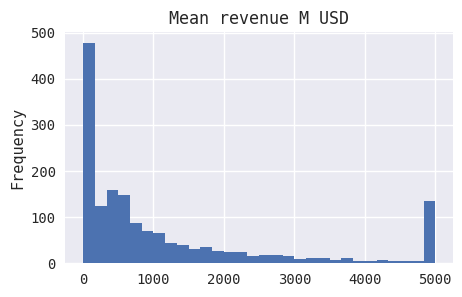

In [16]:
# --- Check revenues ---

_df = sheets["Revenue"].copy()
_df = keep_us_only(_df)
_df["Short Ticker"] = shorten_ticker(_df["Ticker"])
_df = _df.loc[_df["Short Ticker"].isin(all_valid_tickers)].reset_index(drop=True)
assert _df["Short Ticker"].duplicated().sum() == 0
_df["Mean Revenue"] = _df.filter(regex="^Q\d \d\d").mean(axis=1)
print(_df["Mean Revenue"].describe())
display(_df.sort_values("Mean Revenue").head(5))
display(_df.sort_values("Mean Revenue").tail(10))
_df["Mean Revenue"].clip(upper=5000).plot(
    kind="hist", bins=30, figsize=(5, 3), title="Mean revenue M USD"
)
display(_df.loc[_df["Ticker"] == "FCMCQ US Equity"].iloc[0].dropna())
_ = _

In [17]:
def filter_tickers(
    revenue_sheet, tickers, minimum_high_revenue: float = 0, drop_zero_revenue: bool = False
):
    _df = revenue_sheet.copy()
    print(f"n records = {len(_df)}")
    
    # Keep US only
    _df = keep_us_only(_df)
    print(f"n records = {len(_df)}")
    
    # Keep big companies only
    # WARNING: future-looking!
    print(f"- only keep companies with highest revenue > {minimum_high_revenue}M USD")
    _df = _df.loc[_df.iloc[:, 3:].max(axis=1) > minimum_high_revenue].reset_index(drop=True)
    print(f"n records = {len(_df)}")

    # Keep positive revenue only
    if drop_zero_revenue:
        print(f"- only keep companies non-zero revenues")
        _df = _df.loc[~(_df.iloc[:, 3:].abs() < 0.0001).any(axis=1)].reset_index(drop=True)
    print(f"n records = {len(_df)}")
    
    # Short ticker name
    print(f"- intersect revenue and master tickers")
    _df.insert(3, "Short Ticker", shorten_ticker(_df["Ticker"]))
    print("duplicated short tickers:", _df["Short Ticker"].duplicated().sum())

    # Tickers of interest
    new_tickers = tickers & set(_df["Short Ticker"])
    print(f"n tickers of interests = {len(new_tickers)} / {len(tickers)}")
    
    return new_tickers

In [18]:
# --- Filter out tickers with low revenues ---

dht(sheets["Revenue"])
tickers = filter_tickers(
    sheets["Revenue"], all_valid_tickers, minimum_high_revenue=MIN_HIGH_REVENUE, drop_zero_revenue=True
)
print(len(tickers), list(tickers)[:10], "...")

,Name,Ticker,BCY year,Q4 21,Q3 21,Q2 21,Q1 21,Q4 20,Q3 20,Q2 20,Q1 20,Q4 19,Q3 19,Q2 19,Q1 19,Q4 18,Q3 18,Q2 18,Q1 18,Q4 17,Q3 17,Q2 17,Q1 17,Q4 16,Q3 16,Q2 16,Q1 16,Q4 15,Q3 15,Q2 15,Q1 15,Q4 14,Q3 14,Q2 14,Q1 14,Q4 13,Q3 13,Q2 13,Q1 13,Q4 12,...,Q2 07,Q1 07,Q4 06,Q3 06,Q2 06,Q1 06,Q4 05,Q3 05,Q2 05,Q1 05,Q4 04,Q3 04,Q2 04,Q1 04,Q4 03,Q3 03,Q2 03,Q1 03,Q4 02,Q3 02,Q2 02,Q1 02,Q4 01,Q3 01,Q2 01,Q1 01,Q4 00,Q3 00,Q2 00,Q1 00,Q4 99,Q3 99,Q2 99,Q1 99,Q4 98,Q3 98,Q2 98,Q1 98,Q2 22,Q1 22
0,CLARUS THERAPEUTICS HOLDINGS,CRXT US Equity,2022.0,4.562000,4.286000,0.00,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENDO INTERNATIONAL PLC,ENDPQ US Equity,2022.0,789.429000,772.028000,713.83,717.919000,760.221000,634.860000,687.588000,820.405000,764.800000,729.426000,699.727000,720.411000,786.389000,745.466,714.696000,700.527000,768.640000,786.887,875.731000,1037.600000,1241.513000,884.335000,920.887000,963.539000,1073.697000,745.727000,735.166,714.128000,662.877000,654.116,592.848,470.842,584.946000,661.319,712.148000,658.494,749.82,...,257.147,254.409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1713,CME GROUP INC,CME US Equity,NaN,1147.299968,1109.900032,1179.20,1253.299968,1098.499968,1080.700032,1182.300032,1522.099968,1138.400000,1277.299968,1272.700032,1179.600000,1236.600064,904.200,1059.600000,1108.999936,900.000000,890.800,924.600000,929.299968,912.899968,841.699968,906.400000,934.200000,813.800000,850.300032,820.000,842.700032,841.100032,762.400,731.600,777.400,687.000000,714.600,816.099968,718.600,1000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1483.000064,1279.000064
1714,HYATT HOTELS-A,H US Equity,NaN,1076.000000,851.000000,663.00,438.000000,424.000000,399.000000,250.000000,993.000000,1275.000064,1215.000064,1288.999936,1240.999936,1138.000000,1074.000,1132.999936,1108.999936,1116.999936,1070.000,1148.999936,1126.000000,923.000000,1088.000000,1164.999936,1088.999936,1108.999936,1053.000000,1112.000,1054.000000,1079.000064,1104.000,1158.000,1074.000,1091.000064,1026.000,1092.000000,975.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


n records = 1715
n records = 1685
- only keep companies with highest revenue > 1000M USD
n records = 853
- only keep companies non-zero revenues
n records = 851
- intersect revenue and master tickers
duplicated short tickers: 8
n tickers of interests = 827 / 3794
827 ['CDW', 'USB', 'ACM', 'LNW', 'NSIT', 'UNP', 'ILMN', 'TSN', 'ORLY', 'ASH'] ...


### Revenue and other metrics

In [19]:
# --- Overview of all available metrics ---

for s_name in sheet_names[1:]:
    print(f"{s_name} {sheets[s_name].shape} {sheets[s_name].notnull().sum().sum()}")

Revenue (1715, 101) 78073
EBITDA (1715, 101) 72785
EBIT (4009, 101) 80830
Interest Expense (4008, 101) 70191
Net Income (4009, 101) 84866
Total Assets (4009, 101) 84406
ST Debt (4008, 101) 83184
LT Debt (4008, 101) 84306
Equity (4008, 101) 84225
Inventories (4008, 101) 76441
Acc Receivable (4008, 101) 81331
Acc Payable (4008, 101) 73915
Cash (4008, 101) 84365


In [20]:
# --- Aux function to transform quarter columns

_year_end_mapping = {"2": "20", "1": "20", "0": "20", "9": "19", "8": "19"}


def rename_quarters_columns(df: pd.DataFrame) -> None:
    old_qcols = [x for x in df.columns if (len(x) == 5) and (x[0] == "Q") and (x[2] == " ")]
    new_qcols = [
        _year_end_mapping[x[-2]] + x[-2:] + x[:2] for x in old_qcols
    ]
    assert all(len(x) == 6 for x in new_qcols)
    df.rename(columns=dict(zip(old_qcols, new_qcols)), inplace=True)
    

_df = pd.DataFrame({"Ticker": ["ADD", "BDD"], "Q3 21": [0, 1.3], "Q4 21": [1.2, 1.34]})
_df_expected = pd.DataFrame({"Ticker": ["ADD", "BDD"], "2021Q3": [0, 1.3], "2021Q4": [1.2, 1.34]})
rename_quarters_columns(_df)
pd.testing.assert_frame_equal(_df, _df_expected)

In [21]:
# --- Transform all the metric spreadsheets ---

wide_sheets = {}
narrow_sheets = {}

for s_name in sheet_names[1:]:
    print(f"-- {s_name} --")
    _df = sheets[s_name].copy()
    print(f"n records = {len(_df)}")
    _df = keep_us_only(_df)
    print(f"n records = {len(_df)}")
    print("duplicates: ", _df["Ticker"].duplicated().sum())
    _df = _df.loc[~(_df["BCY year"] > 2050)].reset_index(drop=True)
    print("duplicates (correct BCY): ", _df["Ticker"].duplicated().sum())
    _df.insert(3, "Short Ticker", shorten_ticker(_df["Ticker"]))
    _df = _df.loc[_df["Short Ticker"].isin(tickers)].reset_index(drop=True)
    _df = _df.iloc[:, 3:].set_index("Short Ticker")
    assert _df.index.is_unique
    rename_quarters_columns(_df)
    print(f"{s_name}: {_df.shape} {_df.notnull().sum().sum()}")
    wide_sheets[s_name] = _df
    _df_melted = _df.reset_index().melt(id_vars="Short Ticker", var_name="Quarter", value_name=s_name)
    assert (_df_melted["Quarter"].str.len() == 6).all()
    _df_melted = _df_melted.set_index(["Short Ticker", "Quarter"])
    assert _df_melted.index.is_unique
    narrow_sheets[s_name] = _df_melted[s_name]
    print(f"{s_name} melted: {_df_melted.shape} {_df_melted.notnull().sum().sum()}")
    
dht(_df)
dht(_df_melted)

-- Revenue --
n records = 1715
n records = 1685
duplicates:  11
duplicates (correct BCY):  11
Revenue: (827, 98) 46476
Revenue melted: (81046, 1) 46476
-- EBITDA --
n records = 1715
n records = 1685
duplicates:  11
duplicates (correct BCY):  11
EBITDA: (827, 98) 42730
EBITDA melted: (81046, 1) 42730
-- EBIT --
n records = 4009
n records = 3933
duplicates:  661
duplicates (correct BCY):  11
EBIT: (827, 98) 43197
EBIT melted: (81046, 1) 43197
-- Interest Expense --
n records = 4008
n records = 3932
duplicates:  661
duplicates (correct BCY):  11
Interest Expense: (827, 98) 36907
Interest Expense melted: (81046, 1) 36907
-- Net Income --
n records = 4009
n records = 3933
duplicates:  661
duplicates (correct BCY):  11
Net Income: (827, 98) 46484
Net Income melted: (81046, 1) 46484
-- Total Assets --
n records = 4009
n records = 3933
duplicates:  661
duplicates (correct BCY):  11
Total Assets: (827, 98) 46140
Total Assets melted: (81046, 1) 46140
-- ST Debt --
n records = 4008
n records = 39

,2021Q4,2021Q3,2021Q2,2021Q1,2020Q4,2020Q3,2020Q2,2020Q1,2019Q4,2019Q3,2019Q2,2019Q1,2018Q4,2018Q3,2018Q2,2018Q1,2017Q4,2017Q3,2017Q2,2017Q1,2016Q4,2016Q3,2016Q2,2016Q1,2015Q4,2015Q3,2015Q2,2015Q1,2014Q4,2014Q3,2014Q2,2014Q1,2013Q4,2013Q3,2013Q2,2013Q1,2012Q4,2012Q3,2012Q2,2012Q1,...,2007Q2,2007Q1,2006Q4,2006Q3,2006Q2,2006Q1,2005Q4,2005Q3,2005Q2,2005Q1,2004Q4,2004Q3,2004Q2,2004Q1,2003Q4,2003Q3,2003Q2,2003Q1,2002Q4,2002Q3,2002Q2,2002Q1,2001Q4,2001Q3,2001Q2,2001Q1,2000Q4,2000Q3,2000Q2,2000Q1,1999Q4,1999Q3,1999Q2,1999Q1,1998Q4,1998Q3,1998Q2,1998Q1,2022Q2,2022Q1
Short Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENDPQ,1507.196000,1568.665000,1545.172000,1427.775,1213.437000,1679.738000,1780.087000,1531.538000,1454.531000,1526.250000,1446.949000,981.739,1149.113000,1118.885000,1098.788000,980.412,986.605,738.393000,616.534000,617.589000,517.250000,561.577000,667.822000,221.968,272.348000,836.111000,2529.735000,377.461,405.696000,708.529000,1427.244000,1041.280000,526.597000,594.085000,505.608,340.517000,529.689,256.917,391.946,248.303,...,445.829,730.857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SPNX,NaN,NaN,NaN,NaN,NaN,207.781000,278.409000,252.221000,272.624000,259.889000,234.132000,151.568,158.050000,104.690000,118.512000,90.438,172.000,167.025000,177.772000,151.766000,187.591000,278.155000,485.847000,559.238,564.017000,533.674000,500.262000,414.829,393.046000,320.042000,201.653000,145.848000,196.047000,90.651000,65.399,77.075000,91.199,79.086,143.037,135.758,...,36.529,31.986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CME,2834.899968,1459.399936,1080.999936,936.400,1633.200000,1332.099968,1405.400064,851.699968,1551.399936,1210.099968,937.699968,997.400,1374.499968,1406.300032,1098.899968,784.600,1903.600,1631.100032,1362.300032,1287.800064,1868.600064,1420.499968,1161.100032,1146.000,1692.600064,1434.300032,1151.000064,1694.800,1366.099968,1087.900032,1037.299968,1053.699968,2469.700096,2064.999936,1968.000,1843.399936,1604.700,2016.900,1293.200,1061.700,...,NaN,1139.793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1879.500032,2045.699968
H,960.000000,2417.999872,1144.000000,1078.000,1207.000064,1778.000000,1438.000000,1194.000000,893.000000,660.000000,515.000000,547.000,570.000000,1014.000000,628.000000,1160.000,503.000,383.000000,400.000000,374.000000,482.000000,544.000000,642.000000,771.000,457.000000,569.000000,644.000000,563.000,685.000000,263.000000,553.000000,765.000000,454.000000,774.000000,718.000,330.000000,413.000,446.000,404.000,542.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1428.000000,1023.000000


,,Cash
Short Ticker,Quarter,
ENDPQ,2021Q4,1507.196000
SPNX,2021Q4,NaN
CME,2022Q1,2045.699968
H,2022Q1,1023.000000


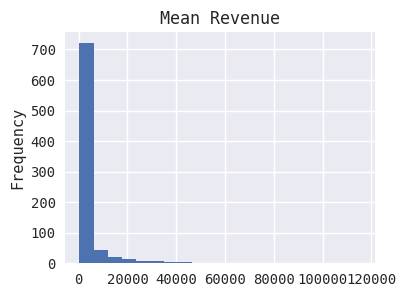

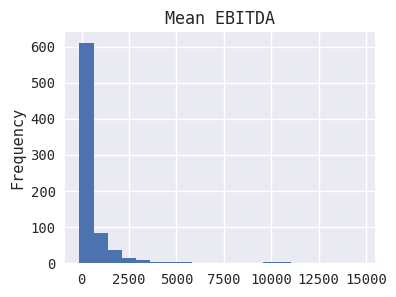

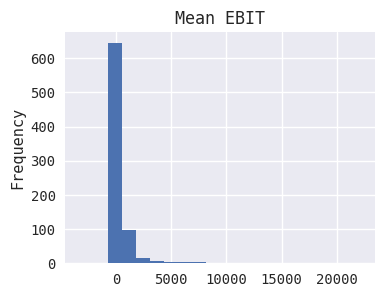

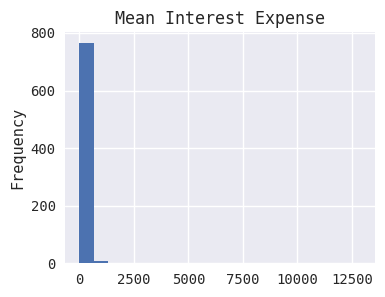

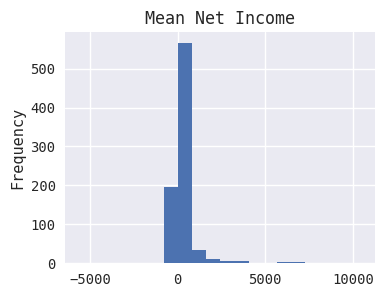

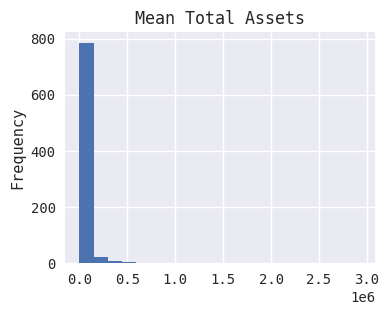

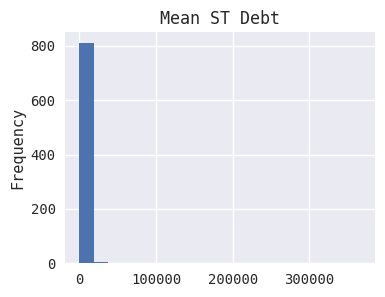

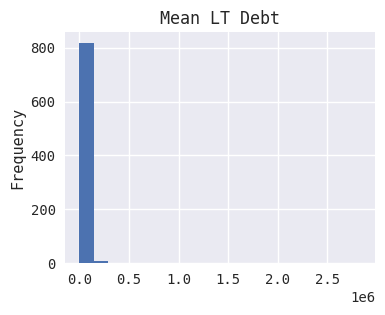

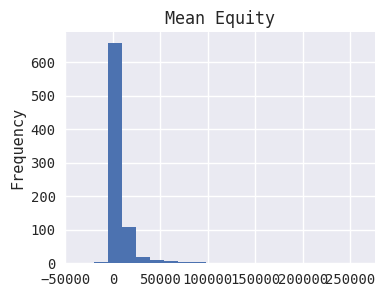

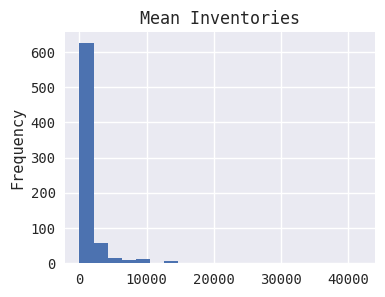

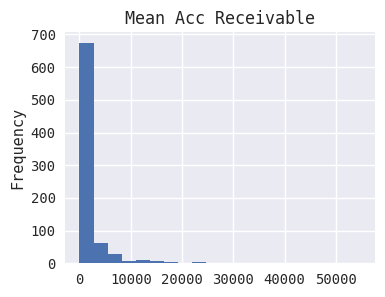

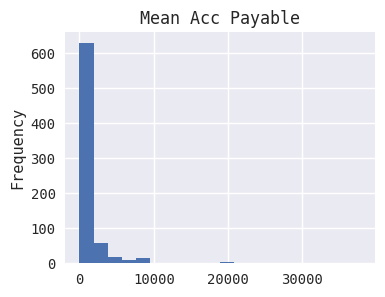

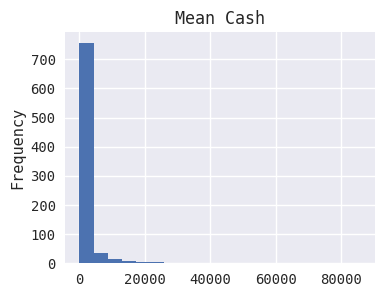

In [22]:
# --- Metric histograms ---

for k, v in wide_sheets.items():
    plt.figure(figsize=(4, 3))
    v.mean(axis=1).plot(kind="hist", bins=20, title=f"Mean {k}")

In [23]:
# --- Weird EBIT-EBITDA cases
(narrow_sheets["EBITDA"] - narrow_sheets["EBIT"]).dropna().sort_values().head(10)

Short Ticker  Quarter
FMCC          2008Q4    -6953.000
              2008Q3    -3777.000
1087117D      2012Q3    -2664.032
FMCC          2008Q2    -1240.000
AXP           2008Q2    -1146.000
CVI           2008Q4     -843.172
MS            2010Q4     -418.000
LEHMQ         2005Q4     -406.000
DVN           2017Q4     -259.000
578903Z       2010Q2     -165.909
dtype: float64

## Putting it all together

### One frame

n records = 81046

n any-valid records = 47090
n all-valid records = 30601

  n valid records:
Revenue             46476
EBITDA              42730
EBIT                43197
Interest Expense    36907
Net Income          46484
Total Assets        46140
ST Debt             45388
LT Debt             46137
Equity              46146
Inventories         40364
Acc Receivable      43984
Acc Payable         38452
Cash                46168
dtype: int64

n records = 81046
n records = 81046
null countdowns = 73892 / 81046
null countdowns = 73892 / 77662
n records = 77662


Bankruptcy Countdown Bankruptcy Quarter BISC Code lvl1  \
Short Ticker Quarter                                                           
ENDPQ        1998Q1                    -98             2022Q3             16   
             1998Q2                    -97             2022Q3             16   
H            2022Q1                   <NA>                NaN             11   
             2022Q2                   <NA>                NaN             11   

                      Revenue  EBITDA  EBIT  Interest Expense  Net Income  \
Short Ticker Quarter                                                        
ENDPQ        1998Q1       NaN     NaN   NaN               NaN         NaN   
             1998Q2       NaN     NaN   NaN               NaN         NaN   
H            2022Q1       NaN     NaN   NaN              40.0         NaN   
             2022Q2       NaN     NaN   NaN              38.0         NaN   

                      Total Assets  ST Debt      LT Debt  Equity  Inventories  \
Short Ticker Quarter                                                            
ENDPQ        1998Q1            NaN      NaN          NaN     NaN          NaN   
             1998Q2            NaN      NaN          NaN     NaN          NaN   
H            2022Q1            NaN     41.0  4136.999936  3524.0          8.0   
             2022Q2            NaN     41.0  4092.000000  3612.0          8.0   

                      Acc Receivable  Acc Payable    Cash  
Short Ticker Quarter                                       
ENDPQ        1998Q1              NaN          NaN     NaN  
             1998Q2              NaN          NaN     NaN  
H            2022Q1            655.0        546.0  1023.0  
             2022Q2            699.0        554.0  1428.0

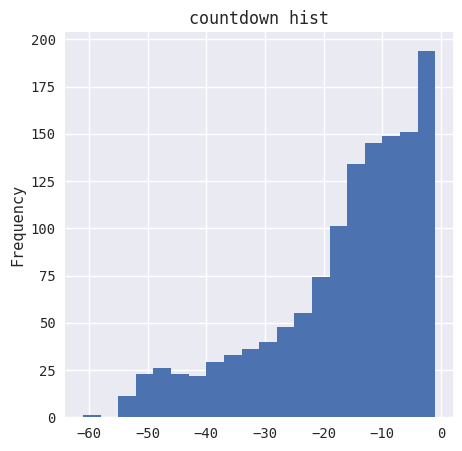

In [24]:
# --- Assemble the frame ---

# Concatenate features
_df = pd.concat(narrow_sheets.values(), axis=1)
print(f"n records = {len(_df)}")

_df = _df.sort_index()
print()
print(f"n any-valid records = {_df.notnull().any(axis=1).sum()}")
print(f"n all-valid records = {_df.notnull().all(axis=1).sum()}")

print("\n  n valid records:")
print(_df.notnull().sum())

# Add bankcruptcy quarter
print()
print(f"n records = {len(_df)}")
_df = pd.merge(
    master_df[[
        "Short Ticker", 
        "Bankruptcy Quarter", 
        # "Bankruptcy Date", 
        "BISC Code lvl1"
    ]],
    _df.reset_index(),
    on=["Short Ticker"],
    how="inner",
)
print(f"n records = {len(_df)}")
_df.insert(
    0, "Bankruptcy Countdown", 
    encode_quarter(_df["Quarter"]) - encode_quarter(_df["Bankruptcy Quarter"])
)
print(f'null countdowns = {_df["Bankruptcy Quarter"].isnull().sum()} / {len(_df)}')

# Filter out records at and after bankruptcy
_df = _df.loc[
    _df["Bankruptcy Countdown"].isnull() | (_df["Bankruptcy Countdown"] < 0)
].reset_index(drop=True)
print(f'null countdowns = {_df["Bankruptcy Quarter"].isnull().sum()} / {len(_df)}')

print(f"n records = {len(_df)}")

_df = _df.set_index(["Short Ticker", "Quarter"])
frame = _df

dht(frame)
_ = frame.dropna()["Bankruptcy Countdown"].plot(kind="hist", bins=20, title="countdown hist")

In [25]:
# --- Check for low metric values ---

for col in ["Revenue", "EBITDA", "Interest Expense"]:
    print(f'zero {col} count = {(frame[col].abs() < 0.0001).sum()}')
    print(f'neg  {col} count = {(frame[col] < -0.0001).sum()}')

zero Revenue count = 0
neg  Revenue count = 29
zero EBITDA count = 5
neg  EBITDA count = 2118
zero Interest Expense count = 637
neg  Interest Expense count = 2


In [26]:
# --- Metric history of a random company --- 

_random_tickers = np.random.choice(frame.reset_index()["Short Ticker"].unique(), size=10, replace=False)
print(_random_tickers)
frame.loc[
    (frame.index.get_level_values(0) == _random_tickers[0])
    & frame["Bankruptcy Countdown"].between(-10, 10)
]

['JBHT' 'MUSA' 'TGT' 'OMI' 'LEG' 'PRIM' 'RPM' 'JNJ' 'UNH' '1235274D']


,,Bankruptcy Countdown,Bankruptcy Quarter,BISC Code lvl1,Revenue,EBITDA,EBIT,Interest Expense,Net Income,Total Assets,ST Debt,LT Debt,Equity,Inventories,Acc Receivable,Acc Payable,Cash
Short Ticker,Quarter,,,,,,,,,,,,,,,,


In [27]:
# --- Features ---

frame["Net Profitability"] = frame["Net Income"] / frame["Revenue"]
frame["Operating Profitability"] = frame["EBIT"] / frame["Revenue"]
frame["Equity Ratio"] = frame["Equity"] / frame["Total Assets"]
frame["Net Leverage"] = (
    (frame["ST Debt"] + frame["LT Debt"] - frame["Acc Payable"] - frame["Cash"]) / frame["EBITDA"]
)
frame["Cost of Debt"] = (
    frame["Interest Expense"] / (frame["ST Debt"] + frame["LT Debt"] - frame["Acc Payable"])
)

frame["ICR"] = frame["EBIT"] / frame["Interest Expense"]

frame["Inventory Ratio"] = frame["Inventories"] / frame["Revenue"]
frame["Receivables Ratio"] = frame["Acc Receivable"] / frame["Revenue"]

dht(frame)

Bankruptcy Countdown Bankruptcy Quarter BISC Code lvl1  \
Short Ticker Quarter                                                           
ENDPQ        1998Q1                    -98             2022Q3             16   
             1998Q2                    -97             2022Q3             16   
H            2022Q1                   <NA>                NaN             11   
             2022Q2                   <NA>                NaN             11   

                      Revenue  EBITDA  EBIT  Interest Expense  Net Income  \
Short Ticker Quarter                                                        
ENDPQ        1998Q1       NaN     NaN   NaN               NaN         NaN   
             1998Q2       NaN     NaN   NaN               NaN         NaN   
H            2022Q1       NaN     NaN   NaN              40.0         NaN   
             2022Q2       NaN     NaN   NaN              38.0         NaN   

                      Total Assets  ST Debt      LT Debt  Equity  Inventories  \
Short Ticker Quarter                                                            
ENDPQ        1998Q1            NaN      NaN          NaN     NaN          NaN   
             1998Q2            NaN      NaN          NaN     NaN          NaN   
H            2022Q1            NaN     41.0  4136.999936  3524.0          8.0   
             2022Q2            NaN     41.0  4092.000000  3612.0          8.0   

                      Acc Receivable  Acc Payable    Cash  Net Profitability  \
Short Ticker Quarter                                                           
ENDPQ        1998Q1              NaN          NaN     NaN                NaN   
             1998Q2              NaN          NaN     NaN                NaN   
H            2022Q1            655.0        546.0  1023.0                NaN   
             2022Q2            699.0        554.0  1428.0                NaN   

                      Operating Profitability  Equity Ratio  Net Leverage  \
Short Ticker Quarter                                                        
ENDPQ        1998Q1                       NaN           NaN           NaN   
             1998Q2                       NaN           NaN           NaN   
H            2022Q1                       NaN           NaN           NaN   
             2022Q2                       NaN           NaN           NaN   

                      Cost of Debt  ICR  Inventory Ratio  Receivables Ratio  
Short Ticker Quarter                                                         
ENDPQ        1998Q1            NaN  NaN              NaN                NaN  
             1998Q2            NaN  NaN              NaN                NaN  
H            2022Q1       0.011013  NaN              NaN                NaN  
             2022Q2       0.010617  NaN              NaN                NaN

In [28]:
# --- Remove infinite values ---

display(frame.describe())
frame.replace([np.inf, -np.inf], np.nan, inplace=True)
display(frame.describe())

,Bankruptcy Countdown,Revenue,EBITDA,EBIT,Interest Expense,Net Income,Total Assets,ST Debt,LT Debt,Equity,Inventories,Acc Receivable,Acc Payable,Cash,Net Profitability,Operating Profitability,Equity Ratio,Net Leverage,Cost of Debt,ICR,Inventory Ratio,Receivables Ratio
count,3770.000000,46350.000000,42606.000000,43072.000000,36808.000000,46358.000000,4.601600e+04,45264.000000,4.601300e+04,46024.000000,40242.000000,43861.000000,38337.000000,46044.000000,46347.000000,43062.000000,45408.000000,3.717700e+04,3.217500e+04,3.443600e+04,39725.000000,43297.000000
mean,-33.259151,4036.862178,681.986210,514.442250,77.810269,306.997416,5.063062e+04,3370.289534,1.422670e+04,9230.628707,1356.961067,2072.450872,1451.790386,2140.345431,0.043967,0.095866,0.425661,NaN,inf,NaN,2.677344,3.626199
std,23.401225,8831.666150,1886.190144,1902.703660,354.027291,1501.303401,2.236609e+05,26241.290550,1.350023e+05,24456.209106,3327.050205,5389.725110,3801.687302,8184.699320,1.463231,1.162369,1.239097,NaN,NaN,NaN,437.925058,512.614286
min,-98.000000,-27966.000000,-59740.000256,-62324.998144,-134.000000,-61659.000000,9.377600e+01,0.000000,0.000000e+00,-90520.000000,0.000000,0.000000,0.000000,0.000000,-256.217557,-189.375038,-8.492634,-inf,-5.993333e+01,-inf,-14.794393,-111.371376
25%,-50.000000,777.744992,83.730250,45.897500,10.142250,19.970500,3.377950e+03,10.335500,6.886710e+02,1010.987750,103.803500,286.699008,173.938000,141.285743,0.019228,0.042682,0.196905,-8.712388e-01,8.399904e-03,2.257187e+00,0.079077,0.269781
50%,-29.000000,1492.299968,218.308000,142.000000,28.998000,85.577500,8.515904e+03,111.363000,2.124915e+03,2635.175936,465.126000,683.000000,411.620992,458.586000,0.061310,0.101286,0.347891,4.049747e+00,1.344315e-02,5.909512e+00,0.342447,0.490457
75%,-13.000000,3369.562496,593.000000,405.000000,77.000000,274.109744,2.558282e+04,657.427488,6.115300e+03,7781.550080,1270.107456,1636.999936,1114.000000,1366.000000,0.118702,0.176163,0.484542,1.151209e+01,1.979425e-02,1.427143e+01,0.574310,0.686115
max,-1.000000,152079.007744,52428.001280,49722.998784,23484.000256,127140.000000,4.288967e+06,945126.000000,4.208797e+06,516864.999424,86089.998336,374389.000000,78663.999488,288605.995008,39.977320,29.568807,95.343953,inf,inf,inf,87283.673582,106202.302339


,Bankruptcy Countdown,Revenue,EBITDA,EBIT,Interest Expense,Net Income,Total Assets,ST Debt,LT Debt,Equity,Inventories,Acc Receivable,Acc Payable,Cash,Net Profitability,Operating Profitability,Equity Ratio,Net Leverage,Cost of Debt,ICR,Inventory Ratio,Receivables Ratio
count,3770.000000,46350.000000,42606.000000,43072.000000,36808.000000,46358.000000,4.601600e+04,45264.000000,4.601300e+04,46024.000000,40242.000000,43861.000000,38337.000000,46044.000000,46347.000000,43062.000000,45408.000000,37172.000000,32174.000000,33811.000000,39725.000000,43297.000000
mean,-33.259151,4036.862178,681.986210,514.442250,77.810269,306.997416,5.063062e+04,3370.289534,1.422670e+04,9230.628707,1356.961067,2072.450872,1451.790386,2140.345431,0.043967,0.095866,0.425661,4.677842,0.010276,64.748878,2.677344,3.626199
std,23.401225,8831.666150,1886.190144,1902.703660,354.027291,1501.303401,2.236609e+05,26241.290550,1.350023e+05,24456.209106,3327.050205,5389.725110,3801.687302,8184.699320,1.463231,1.162369,1.239097,422.673991,0.592333,1957.133066,437.925058,512.614286
min,-98.000000,-27966.000000,-59740.000256,-62324.998144,-134.000000,-61659.000000,9.377600e+01,0.000000,0.000000e+00,-90520.000000,0.000000,0.000000,0.000000,0.000000,-256.217557,-189.375038,-8.492634,-44503.326426,-59.933333,-3672.147002,-14.794393,-111.371376
25%,-50.000000,777.744992,83.730250,45.897500,10.142250,19.970500,3.377950e+03,10.335500,6.886710e+02,1010.987750,103.803500,286.699008,173.938000,141.285743,0.019228,0.042682,0.196905,-0.871271,0.008400,2.219063,0.079077,0.269781
50%,-29.000000,1492.299968,218.308000,142.000000,28.998000,85.577500,8.515904e+03,111.363000,2.124915e+03,2635.175936,465.126000,683.000000,411.620992,458.586000,0.061310,0.101286,0.347891,4.047536,0.013443,5.746439,0.342447,0.490457
75%,-13.000000,3369.562496,593.000000,405.000000,77.000000,274.109744,2.558282e+04,657.427488,6.115300e+03,7781.550080,1270.107456,1636.999936,1114.000000,1366.000000,0.118702,0.176163,0.484542,11.508559,0.019794,13.577322,0.574310,0.686115
max,-1.000000,152079.007744,52428.001280,49722.998784,23484.000256,127140.000000,4.288967e+06,945126.000000,4.208797e+06,516864.999424,86089.998336,374389.000000,78663.999488,288605.995008,39.977320,29.568807,95.343953,30583.202847,41.000000,239180.000000,87283.673582,106202.302339


In [29]:
frame.notnull().sum()

Bankruptcy Countdown        3770
Bankruptcy Quarter          3770
BISC Code lvl1             77662
Revenue                    46350
EBITDA                     42606
EBIT                       43072
Interest Expense           36808
Net Income                 46358
Total Assets               46016
ST Debt                    45264
LT Debt                    46013
Equity                     46024
Inventories                40242
Acc Receivable             43861
Acc Payable                38337
Cash                       46044
Net Profitability          46347
Operating Profitability    43062
Equity Ratio               45408
Net Leverage               37172
Cost of Debt               32174
ICR                        33811
Inventory Ratio            39725
Receivables Ratio          43297
dtype: int64

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


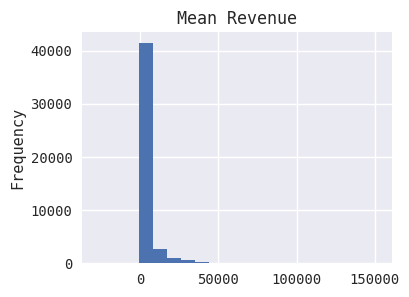

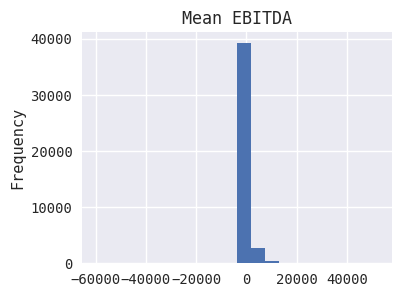

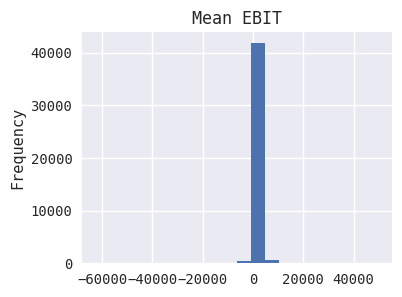

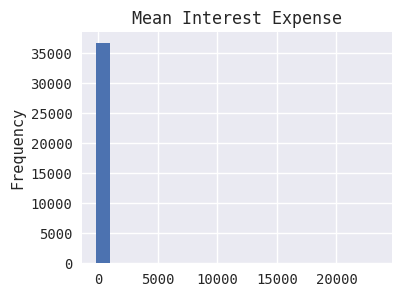

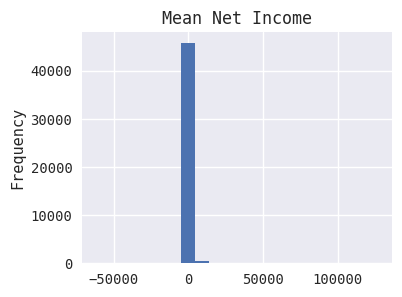

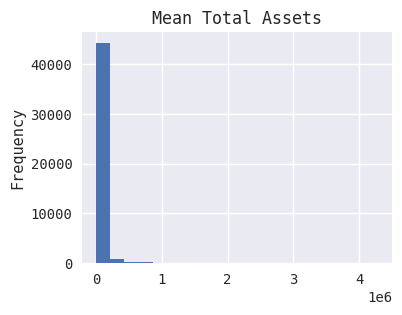

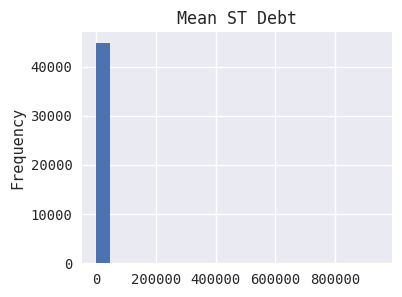

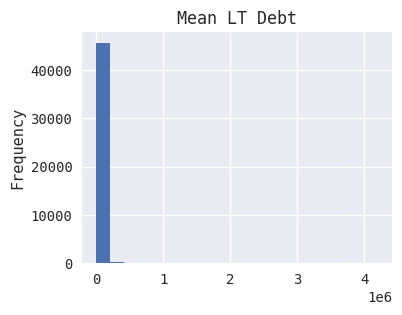

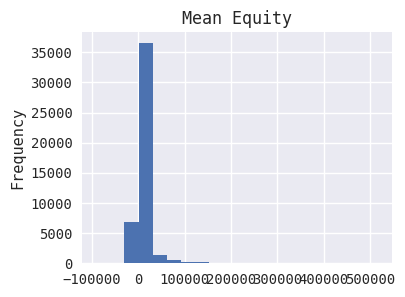

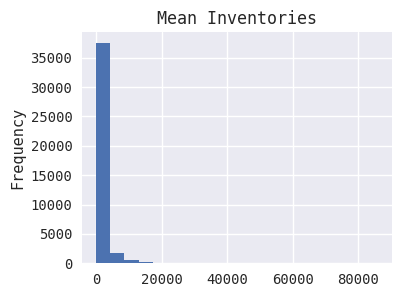

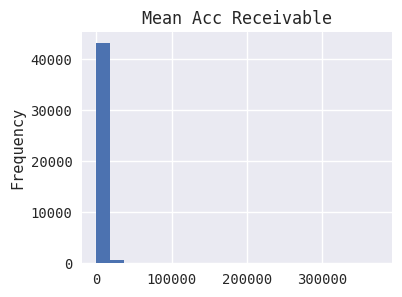

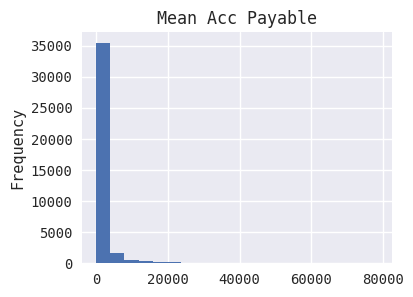

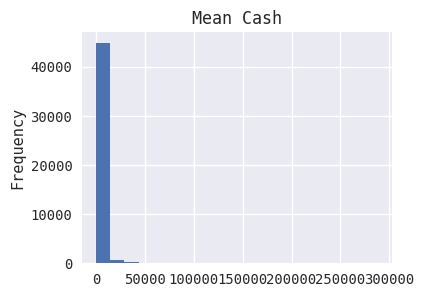

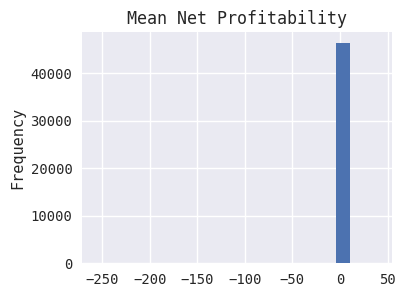

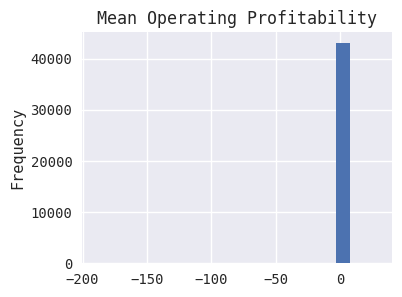

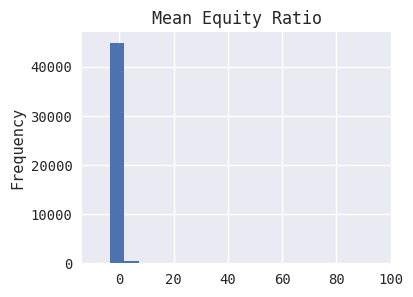

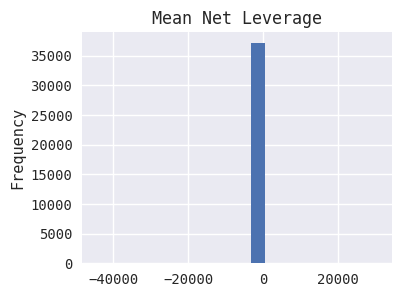

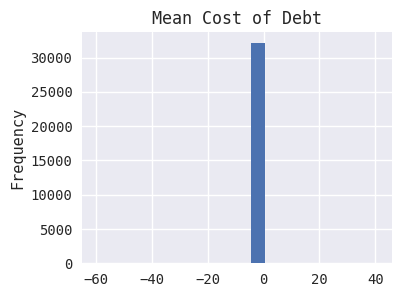

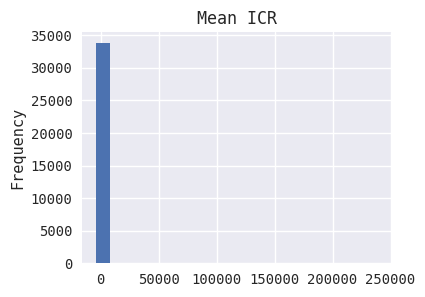

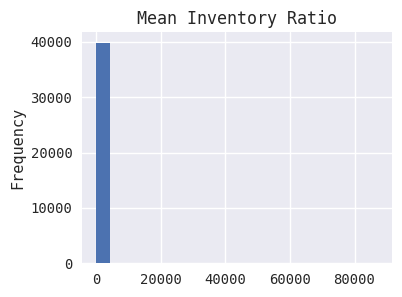

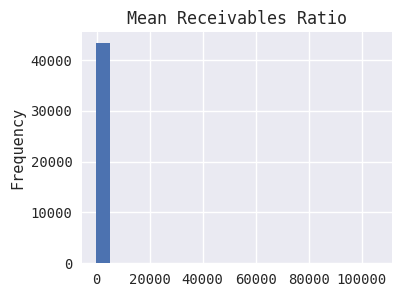

In [30]:
# --- Feature histograms ---
for col in frame.drop(columns=["Bankruptcy Countdown", "Bankruptcy Quarter", "BISC Code lvl1"]).columns:
    plt.figure(figsize=(4, 3))
    frame[col].dropna().plot(kind="hist", bins=20, title=f"Mean {col}")

### More features

In [31]:
dht(frame, 1)

,,Bankruptcy Countdown,Bankruptcy Quarter,BISC Code lvl1,Revenue,EBITDA,EBIT,Interest Expense,Net Income,Total Assets,ST Debt,LT Debt,Equity,Inventories,Acc Receivable,Acc Payable,Cash,Net Profitability,Operating Profitability,Equity Ratio,Net Leverage,Cost of Debt,ICR,Inventory Ratio,Receivables Ratio
Short Ticker,Quarter,,,,,,,,,,,,,,,,,,,,,,,,
ENDPQ,1998Q1,-98,2022Q3,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H,2022Q2,<NA>,NaN,11,NaN,NaN,NaN,38.0,NaN,NaN,41.0,4092.0,3612.0,8.0,699.0,554.0,1428.0,NaN,NaN,NaN,NaN,0.010617,NaN,NaN,NaN


In [32]:
# --- Time-related features ---

frame["Season"] = frame.index.get_level_values(1).str[-1].astype(int)

In [33]:
# - Shift a quarter back

# _df = frame.groupby("Short Ticker").shift(1)
# _df.columns = [f"{c} P1Q" for c in _df.columns]
# _df.loc["WNDXQ"]

# frame_ = pd.concat([frame, _df], axis=1)
# dht(frame_)

# print(frame_.loc["WNDXQ"].dropna(how="all"))

In [34]:
# TO DO: add more features

### Train and test sets

In [35]:
# --- Count valid samples ---

print(list(frame.columns))
dht(frame, 1)
_df = frame
print("all:")
print(f"n records = {len(_df)}")
print(f"n tickers = {_df.index.get_level_values(0).nunique()}")
_df = frame.dropna(how="all", subset=list(narrow_sheets.keys()))
print("\ndrop rows with all NaNs:")
print(f"n records = {len(_df)}")
print(f"n tickers = {_df.index.get_level_values(0).nunique()}")
_df = frame.dropna(how="any", subset=[x for x in _df.columns if not x.startswith("Bankruptcy ")])
print("\ndrop rows with any NaNs:")
print(f"n records = {len(_df)}")
print(f"n tickers = {_df.index.get_level_values(0).nunique()}")

['Bankruptcy Countdown', 'Bankruptcy Quarter', 'BISC Code lvl1', 'Revenue', 'EBITDA', 'EBIT', 'Interest Expense', 'Net Income', 'Total Assets', 'ST Debt', 'LT Debt', 'Equity', 'Inventories', 'Acc Receivable', 'Acc Payable', 'Cash', 'Net Profitability', 'Operating Profitability', 'Equity Ratio', 'Net Leverage', 'Cost of Debt', 'ICR', 'Inventory Ratio', 'Receivables Ratio', 'Season']


,,Bankruptcy Countdown,Bankruptcy Quarter,BISC Code lvl1,Revenue,EBITDA,EBIT,Interest Expense,Net Income,Total Assets,ST Debt,LT Debt,Equity,Inventories,Acc Receivable,Acc Payable,Cash,Net Profitability,Operating Profitability,Equity Ratio,Net Leverage,Cost of Debt,ICR,Inventory Ratio,Receivables Ratio,Season
Short Ticker,Quarter,,,,,,,,,,,,,,,,,,,,,,,,,
ENDPQ,1998Q1,-98,2022Q3,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
H,2022Q2,<NA>,NaN,11,NaN,NaN,NaN,38.0,NaN,NaN,41.0,4092.0,3612.0,8.0,699.0,554.0,1428.0,NaN,NaN,NaN,NaN,0.010617,NaN,NaN,NaN,2


all:
n records = 77662
n tickers = 827

drop rows with all NaNs:
n records = 46964
n tickers = 827

drop rows with any NaNs:
n records = 29928
n tickers = 697


In [36]:
# --- Dividing tickers on train and test (by their bankruptcy quarter)

cutoff_quarter = "2016Q1"

frame_ = frame.dropna(how="any", subset=[x for x in _df.columns if not x.startswith("Bankruptcy ")])

# Bankcruptcy tickers
bankruptcy_quarters = (
    frame_.groupby("Short Ticker")["Bankruptcy Quarter"].last()
    .value_counts(sort=False).sort_index()
)
print(f"n companies overall = {bankruptcy_quarters.sum()}")
print(f"n companies recent = {bankruptcy_quarters[cutoff_quarter:].sum()}")

_b_train_tickers = set(
    frame_.loc[frame_["Bankruptcy Quarter"] < cutoff_quarter].index.get_level_values(0)
)
_b_test_tickers = set(
    frame_.loc[frame_["Bankruptcy Quarter"] >= cutoff_quarter].index.get_level_values(0)
)
print()
print(f"n bankcrupt train tickers = {len(_b_train_tickers)}")
print(f"n bankcrupt test tickers = {len(_b_test_tickers)}")

# Control tickers
_c_train_test_tickers = (
    frame_.loc[frame_["Bankruptcy Quarter"].isnull()].index.get_level_values(0).unique().values
)
np.random.shuffle(_c_train_test_tickers)
_n_c_train_tickers = int(
    len(_c_train_test_tickers) * len(_b_train_tickers) / (len(_b_train_tickers) + len(_b_test_tickers))
)
_c_train_tickers = set(_c_train_test_tickers[:_n_c_train_tickers])
_c_test_tickers = set(_c_train_test_tickers[_n_c_train_tickers:])
print(f"n control train tickers = {len(_c_train_tickers)}")
print(f"n control test tickers = {len(_c_test_tickers)}")

# Combined
train_tickers = _b_train_tickers | _c_train_tickers
test_tickers = _b_test_tickers | _c_test_tickers
print()
print(f"n train tickers = {len(train_tickers)}")
print(f"n test tickers = {len(test_tickers)}")

n companies overall = 65
n companies recent = 23

n bankcrupt train tickers = 42
n bankcrupt test tickers = 23
n control train tickers = 408
n control test tickers = 224

n train tickers = 450
n test tickers = 247


In [37]:
# --- Train and test datasets ---

frame_train = frame_.loc[
    frame_.index.get_level_values(0).isin(train_tickers)
    & (frame_.index.get_level_values(1) < cutoff_quarter)
].copy()
print(f'train: {frame_train["Bankruptcy Quarter"].dropna().min()}..{frame_train["Bankruptcy Quarter"].dropna().max()}')
X_train = frame_train.drop(columns=["Bankruptcy Quarter", "Bankruptcy Countdown"]).copy()
y_train = frame_train["Bankruptcy Countdown"].copy()
print(
    f"n pos train samples = {(y_train == -1).sum()} / {len(y_train)}"
    f" ({(y_train == -1).sum() / len(y_train):.3f})"
)

frame_test = frame_.loc[
    frame_.index.get_level_values(0).isin(test_tickers)
    # & (frame_.index.get_level_values(1) > cutoff_quarter)
].copy()
print(f'test: {frame_test["Bankruptcy Quarter"].dropna().min()}..{frame_test["Bankruptcy Quarter"].dropna().max()}')
X_test = frame_test.drop(columns=["Bankruptcy Quarter", "Bankruptcy Countdown"]).copy()
y_test = frame_test["Bankruptcy Countdown"].copy()
print(
    f"n pos test samples = {(y_test == -1).sum()} / {len(y_test)}"
    f" ({(y_test == -1).sum() / len(y_test):.3f})"
)

train: 2001Q2..2015Q3
n pos train samples = 32 / 11027 (0.003)
test: 2016Q2..2022Q3
n pos test samples = 10 / 10441 (0.001)


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


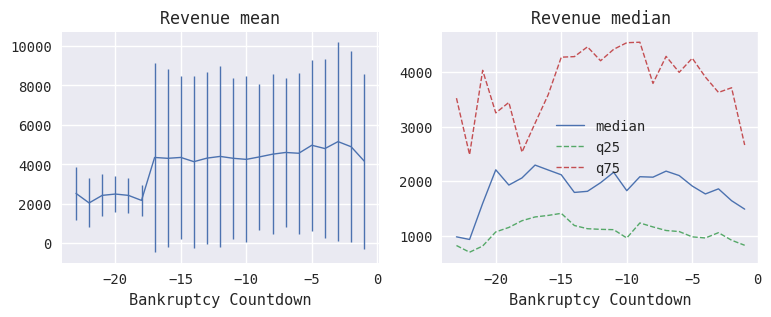

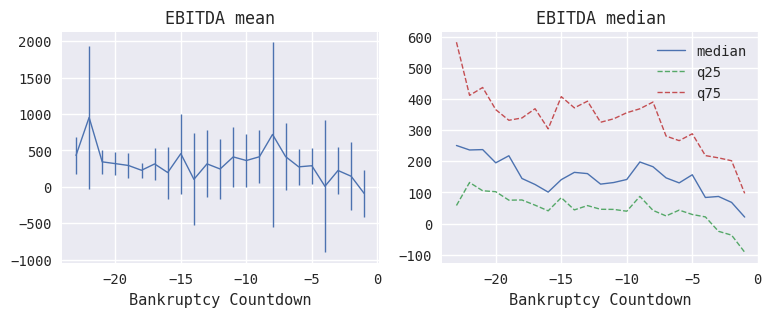

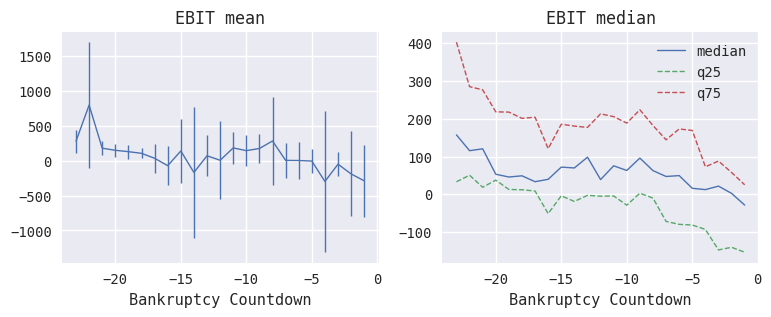

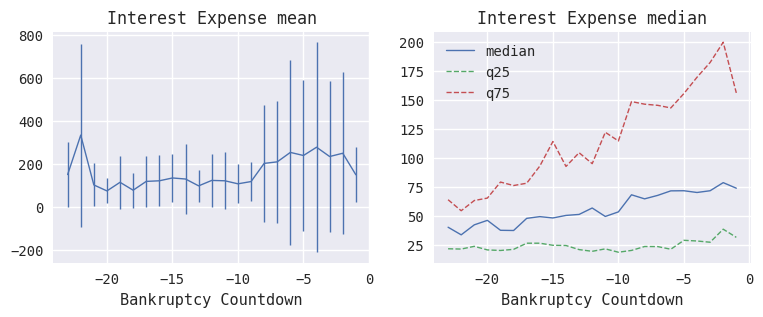

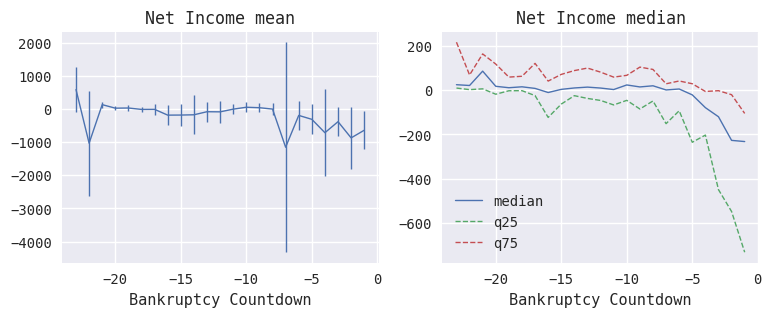

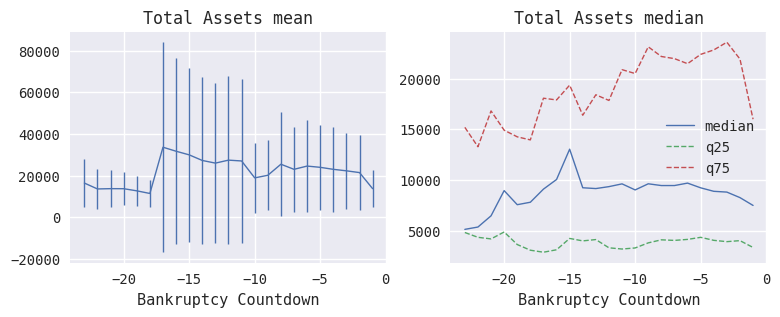

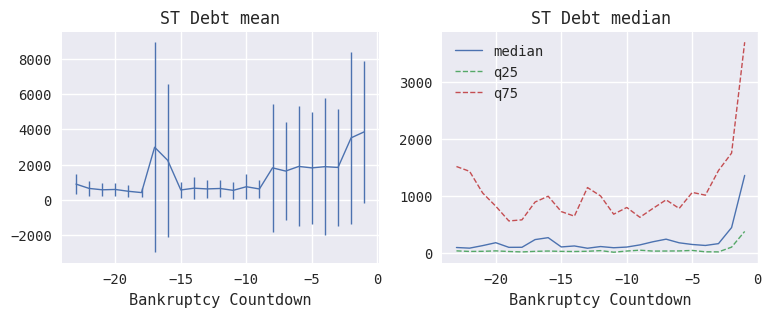

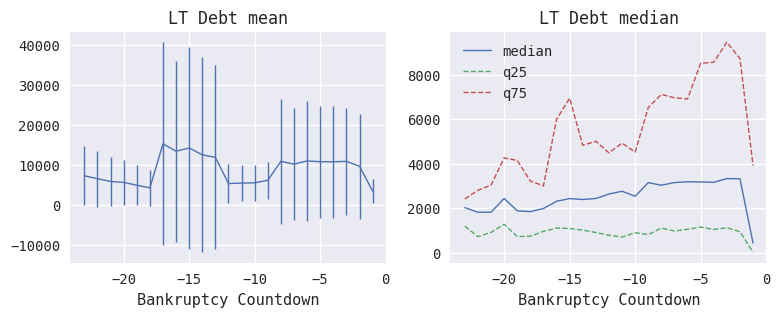

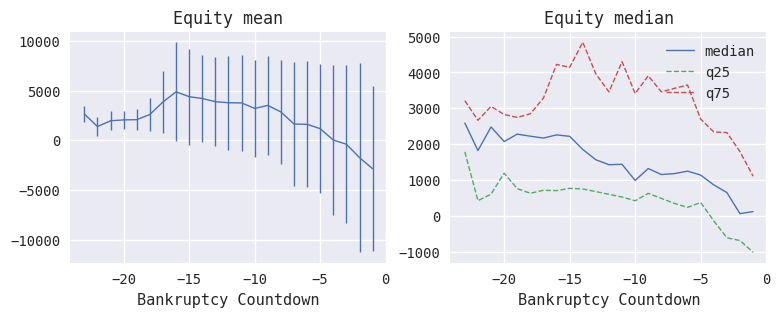

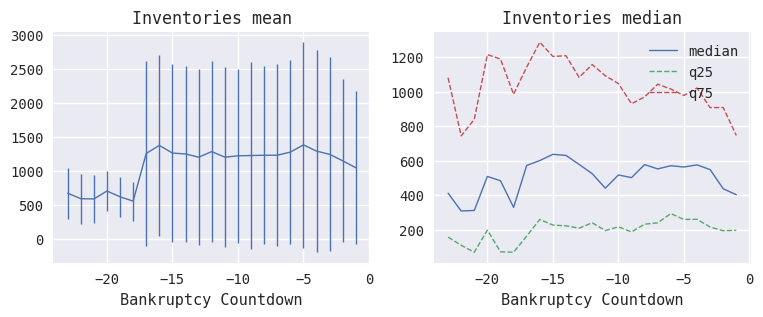

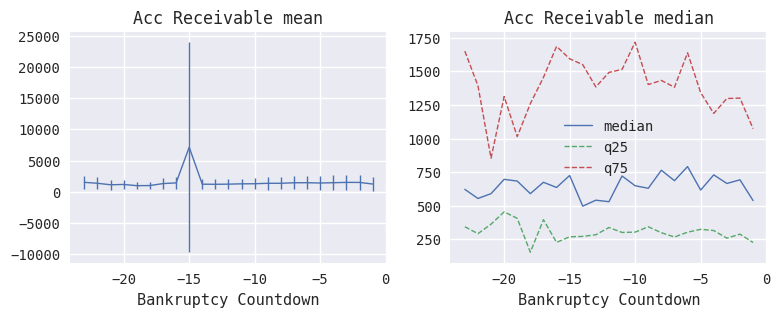

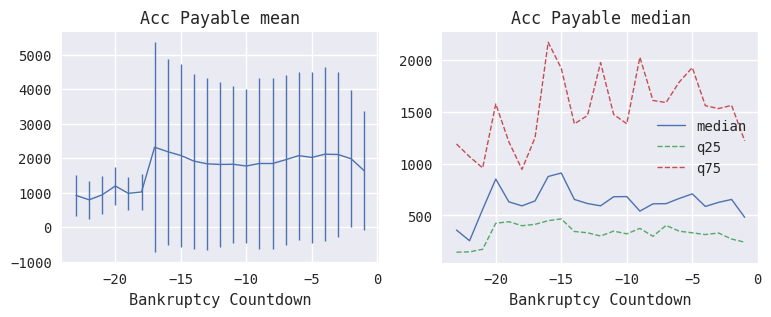

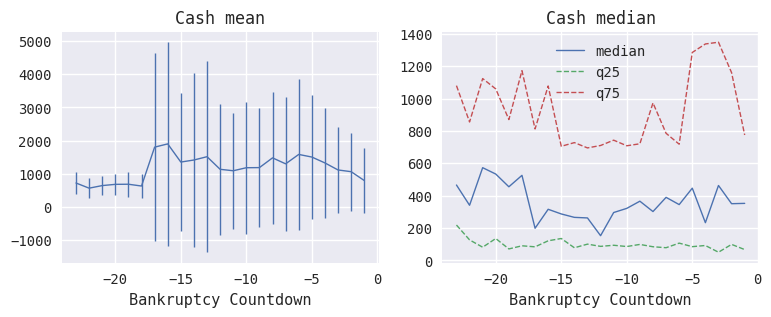

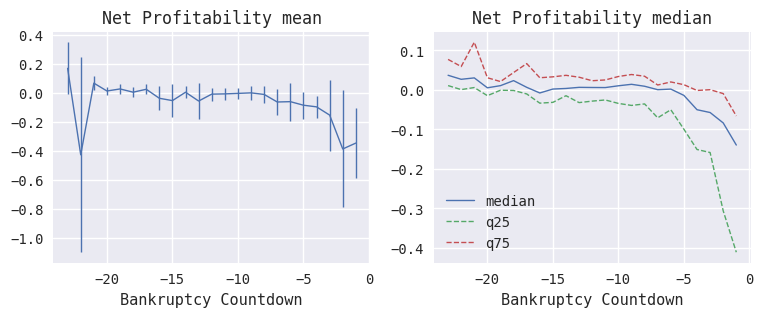

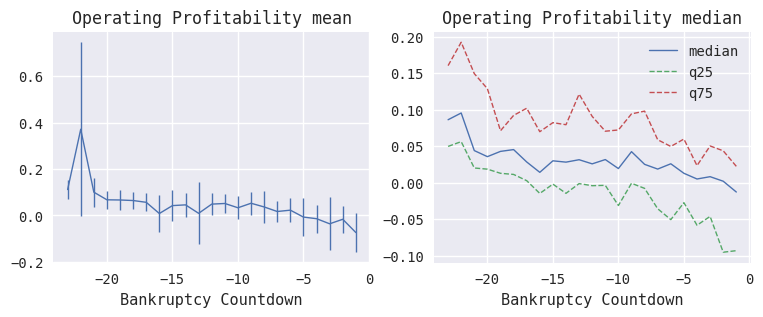

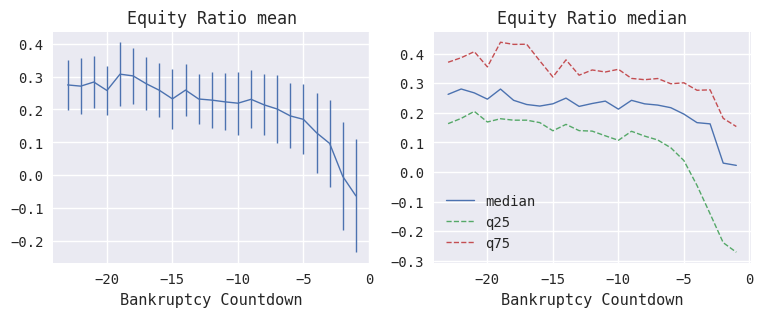

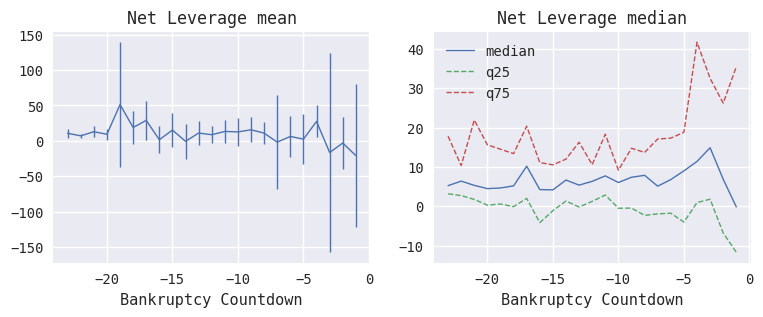

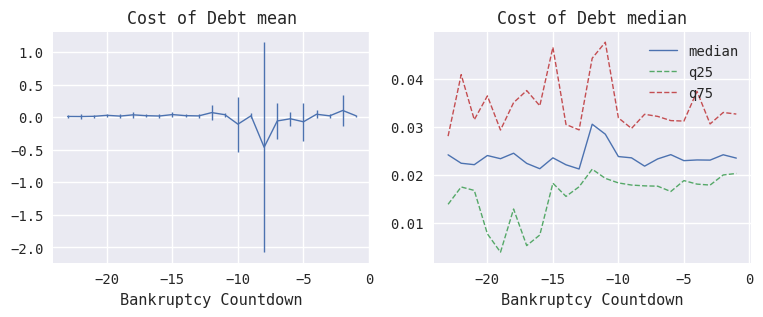

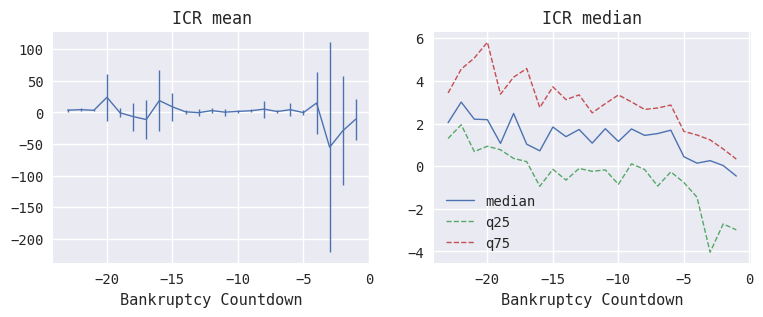

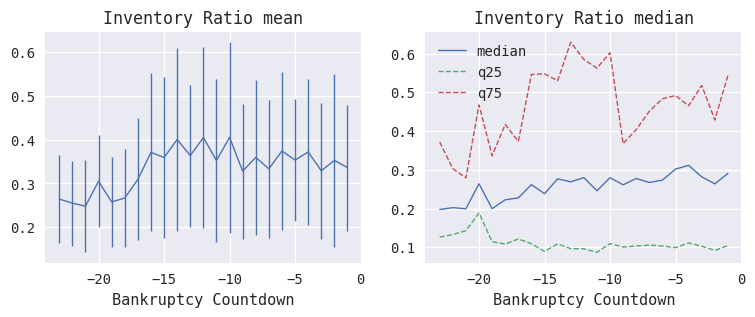

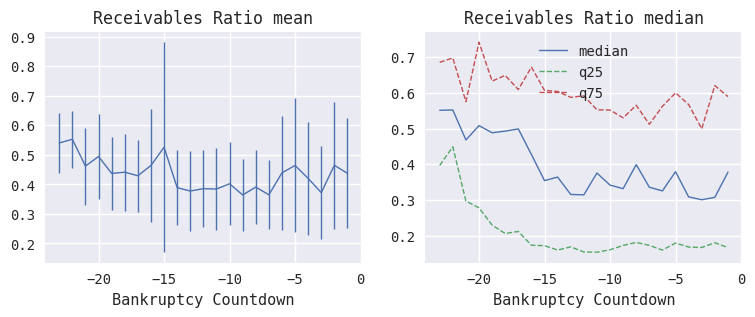

In [38]:
# --- Plotting dependencies ---

for col in X_train.drop(columns=["BISC Code lvl1", "Season"]).columns:
    fig, ax = plt.subplots(1, 2, figsize=(9, 3))
    _agg = frame_train.groupby("Bankruptcy Countdown")[col].agg(
        ["mean", "median", "std", q25, q75, "count"]
    )
    _agg = _agg.loc[_agg["count"] > 5]
    _agg["mean"].plot(title=f"{col} mean", ax=ax[0], yerr=_agg["std"] / 2)
    _agg[["median"]].plot(title=f"{col} median", ax=ax[1])
    _agg[["q25", "q75"]].plot(ax=ax[1], linestyle="--")
_ = _

## Hypothesis 0: We can predict bankcruptcy in the next quarter

- 1 = Bankruptcy next quarter
- 0 = Okay next quarter

In [39]:
def classification_results(
    y_train_, y_test, y_train_hat, y_test_hat, p_train_hat=None, p_test_hat=None,
):
    # mean of sensitivity (TPR) and specificity (TNR)
    print(f"b acc train = {balanced_accuracy_score(y_train_.values, y_train_hat):.2}")
    print(f"b acc test  = {balanced_accuracy_score(y_test_.values, y_test_hat):.2}")
    
    # precision and recall (TPR)
    print()
    print(f"precision train = {precision_score(y_train_.values, y_train_hat):.2}")
    print(f"precision test  = {precision_score(y_test_.values, y_test_hat):.2}")
    print(f"recall train = {recall_score(y_train_.values, y_train_hat):.2}")
    print(f"recall test  = {recall_score(y_test_.values, y_test_hat):.2}")

    # confusion matrix
    print(f"\nconfusion train:")
    print(confusion_matrix(y_train_.values, y_train_hat))
    print(f"\nconfusion test:")
    print(confusion_matrix(y_test_.values, y_test_hat))
    
    # ROC curve plot
    if (p_train_hat is not None) and (p_test_hat is not None):
        _ = RocCurveDisplay.from_predictions(y_train_.values, p_train_hat)


### Logistic regression

In [40]:
def preprocess_X(X):
    return X.drop(columns=["BISC Code lvl1", "Season"])


def preprocess_y(y):
    return (y.replace(pd.NA, -100) == -1).astype(int)

b acc train = 0.53
b acc test  = 0.5

precision train = 0.67
precision test  = 0.0
recall train = 0.062
recall test  = 0.0

confusion train:
[[10994     1]
 [   30     2]]

confusion test:
[[10423     8]
 [   10     0]]



intercept      -6.86
Equity Ratio   -1.48
Cash           -1.16
Equity         -0.84
Revenue         0.73
LT Debt        -0.57
Total Assets   -0.51
ST Debt         0.41
Inventories    -0.41
Acc Payable     0.35
dtype: float64

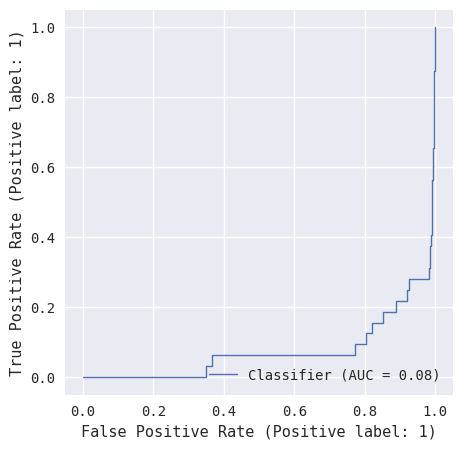

In [41]:
# --- Logistic: No weights ---

X_train_ = preprocess_X(X_train)
y_train_ = preprocess_y(y_train)
X_test_ = preprocess_X(X_test)
y_test_ = preprocess_y(y_test)


m = Pipeline((
    ("s", StandardScaler()),
    ("e", LogisticRegression(penalty="l2", class_weight=None)),
))
m.fit(X_train_, y_train_)
y_train_hat = m.predict(X_train_)
p_train_hat = m.predict_proba(X_train_)[:, 0]
y_test_hat = m.predict(X_test_)
p_test_hat = m.predict_proba(X_test_)[:, 0]

classification_results(
    y_train_, y_test, y_train_hat, y_test_hat, p_train_hat, p_test_hat
)

print()
display(pd.Series(
    np.concatenate([m.named_steps["e"].coef_[0], [m.named_steps["e"].intercept_[0]]]).round(2), 
    index=np.concatenate([X_train_.columns, ['intercept']])
).sort_values(key=lambda x: -abs(x)).head(10))

b acc train = 0.93
b acc test  = 0.96

precision train = 0.032
precision test  = 0.012
recall train = 0.94
recall test  = 1.0

confusion train:
[[10077   918]
 [    2    30]]

confusion test:
[[9589  842]
 [   0   10]]



Equity Ratio       -6.37
ICR                -5.15
intercept          -4.54
Interest Expense    3.30
LT Debt            -3.09
Acc Receivable     -2.40
Cash               -2.06
Total Assets       -1.81
Revenue             1.41
ST Debt             1.30
dtype: float64

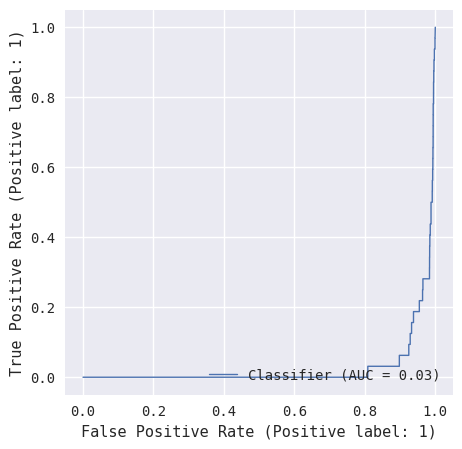

In [42]:
# --- Logistic: Balanced weights ---

X_train_ = preprocess_X(X_train)
y_train_ = preprocess_y(y_train)
X_test_ = preprocess_X(X_test)
y_test_ = preprocess_y(y_test)


m = Pipeline((
    ("s", StandardScaler()),
    ("e", LogisticRegression(penalty="l2", class_weight="balanced")),
))
m.fit(X_train_, y_train_)
y_train_hat = m.predict(X_train_)
p_train_hat = m.predict_proba(X_train_)[:, 0]
y_test_hat = m.predict(X_test_)
p_test_hat = m.predict_proba(X_test_)[:, 0]

classification_results(
    y_train_, y_test, y_train_hat, y_test_hat, p_train_hat, p_test_hat
)

print()
display(pd.Series(
    np.concatenate([m.named_steps["e"].coef_[0], [m.named_steps["e"].intercept_[0]]]).round(2), 
    index=np.concatenate([X_train_.columns, ['intercept']])
).sort_values(key=lambda x: -abs(x)).head(10))

b acc train = 0.84
b acc test  = 0.9

precision train = 0.028
precision test  = 0.0094
recall train = 0.75
recall test  = 0.9

confusion train:
[[10172   823]
 [    8    24]]

confusion test:
[[9480  951]
 [   1    9]]



Equity Ratio              -1.89
intercept                 -1.22
Net Profitability         -0.83
Operating Profitability   -0.48
ST Debt                    0.34
Cash                      -0.32
Equity                    -0.29
Revenue                    0.09
Total Assets               0.00
Inventories                0.00
dtype: float64

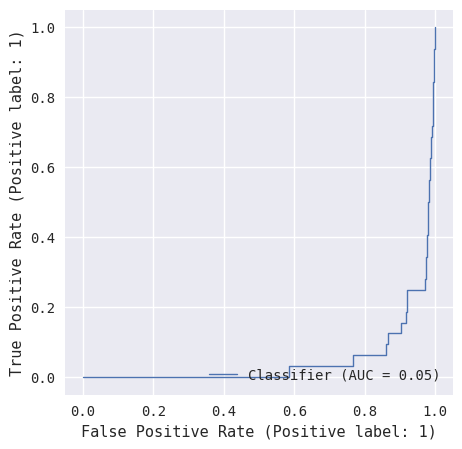

In [43]:
# --- Logistic: Balanced weights + Manual L1 regularization ---

X_train_ = preprocess_X(X_train)
y_train_ = preprocess_y(y_train)
X_test_ = preprocess_X(X_test)
y_test_ = preprocess_y(y_test)


m = Pipeline((
    ("s", StandardScaler()),
    ("e", LogisticRegression(penalty="l1", C=0.005, class_weight="balanced", solver="liblinear")),
))
m.fit(X_train_, y_train_)
y_train_hat = m.predict(X_train_)
p_train_hat = m.predict_proba(X_train_)[:, 0]
y_test_hat = m.predict(X_test_)
p_test_hat = m.predict_proba(X_test_)[:, 0]

classification_results(
    y_train_, y_test, y_train_hat, y_test_hat, p_train_hat, p_test_hat
)

print()
display(pd.Series(
    np.concatenate([m.named_steps["e"].coef_[0], [m.named_steps["e"].intercept_[0]]]).round(2), 
    index=np.concatenate([X_train_.columns, ['intercept']])
).sort_values(key=lambda x: -abs(x)).head(10))

b acc train = 0.84
b acc test  = 0.95

precision train = 0.028
precision test  = 0.0097
recall train = 0.75
recall test  = 1.0

confusion train:
[[10164   831]
 [    8    24]]

confusion test:
[[9414 1017]
 [   0   10]]

LogisticRegression(C=0.01, class_weight='balanced', penalty='l1',
                   solver='liblinear')


Equity Ratio              -3.43
intercept                 -1.81
Net Profitability         -0.79
Cash                      -0.62
ST Debt                    0.56
Operating Profitability   -0.51
Acc Receivable            -0.44
Revenue                    0.41
Total Assets              -0.25
Equity                    -0.17
dtype: float64

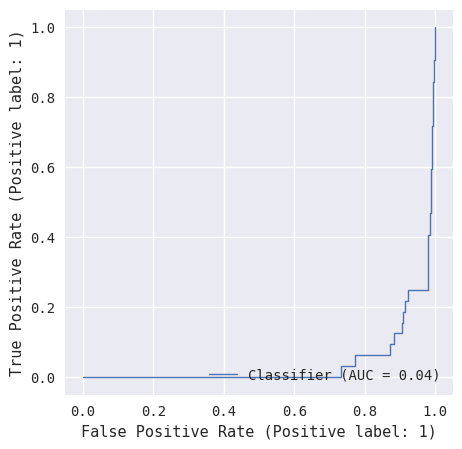

In [44]:
# --- Logistic: Balanced weights + Auto L1 regularization ---

X_train_ = preprocess_X(X_train)
y_train_ = preprocess_y(y_train)
X_test_ = preprocess_X(X_test)
y_test_ = preprocess_y(y_test)


m = GridSearchCV(
    Pipeline((
        ("s", StandardScaler()),
        ("e", LogisticRegression(penalty="l1", class_weight="balanced", solver="liblinear")),
    )),
    {
        'e__C': [0.05, 0.01, 0.2, 0.5, 1.0],
    },
    scoring="balanced_accuracy",
    cv=5,
)
m.fit(X_train_, y_train_)
y_train_hat = m.predict(X_train_)
p_train_hat = m.predict_proba(X_train_)[:, 0]
y_test_hat = m.predict(X_test_)
p_test_hat = m.predict_proba(X_test_)[:, 0]

classification_results(
    y_train_, y_test, y_train_hat, y_test_hat, p_train_hat, p_test_hat
)

print()
best = m.best_estimator_
print(best.named_steps["e"])
display(pd.Series(
    np.concatenate([best.named_steps["e"].coef_[0], [best.named_steps["e"].intercept_[0]]]).round(2), 
    index=np.concatenate([X_train_.columns, ['intercept']])
).sort_values(key=lambda x: -abs(x)).head(10))

### GB Trees

In [45]:
def preprocess_X(X):
    X = X.copy()
    X["BISC Code lvl1"] =  X["BISC Code lvl1"].astype('category')
    X["Season"] =  X["Season"].astype('category')
    return X


def preprocess_y(y):
    return (y.replace(pd.NA, -100) == -1).astype(int)

b acc train = 0.97
b acc test  = 0.93

precision train = 0.047
precision test  = 0.017
recall train = 1.0
recall test  = 0.9

confusion train:
[[10344   651]
 [    0    32]]

confusion test:
[[9922  509]
 [   1    9]]

LGBMClassifier(class_weight='balanced', learning_rate=0.003,
               min_child_samples=5, num_leaves=3, objective='cross_entropy',
               reg_lambda=0.003)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


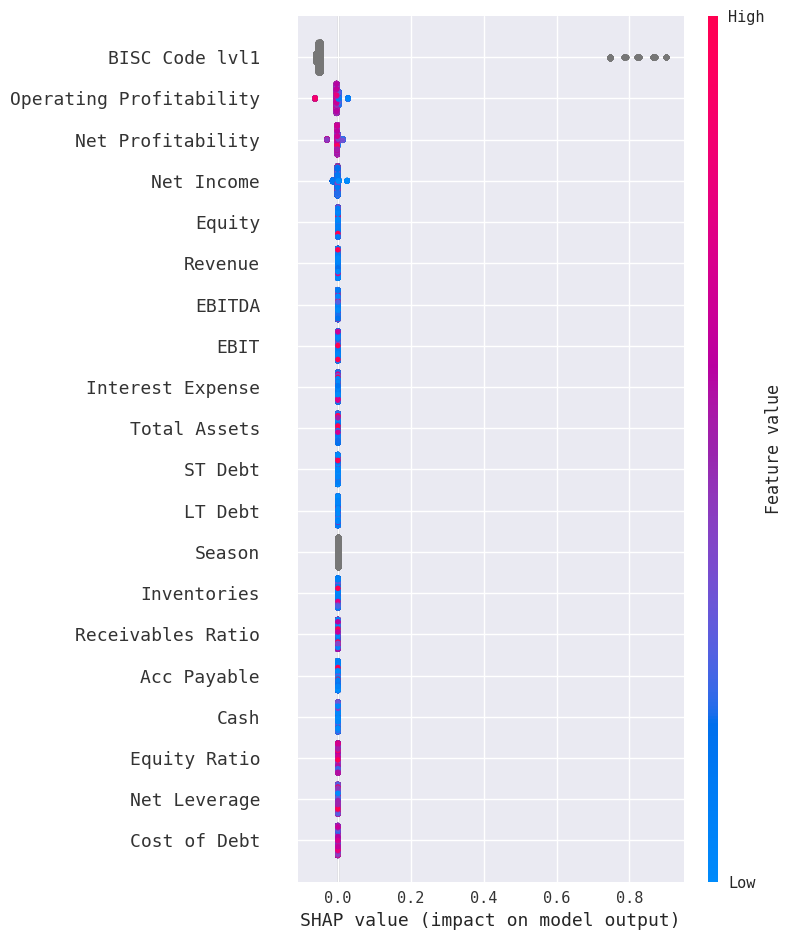

In [46]:
# --- GB Trees: Balanced weights + Auto hyper-parameter tuning ---

X_train_ = preprocess_X(X_train)
y_train_ = preprocess_y(y_train)
X_test_ = preprocess_X(X_test)
y_test_ = preprocess_y(y_test)


m = GridSearchCV(
    LGBMClassifier(
        n_estimators=100, 
        min_child_samples=5,
        objective="cross_entropy",
        class_weight="balanced",
    ),
    {
        'num_leaves': [15, 7, 3],
        'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1],
        'reg_lambda': [0.003, 0.01, 0.3, 1.],
    },
    scoring="balanced_accuracy",
    cv=5,
)
m.fit(X_train_, y_train_)
y_train_hat = m.predict(X_train_)
y_test_hat = m.predict(X_test_)

classification_results(
    y_train_, y_test, y_train_hat, y_test_hat
)

print()
best = m.best_estimator_
print(best)

# explainer = shap.TreeExplainer(best, X_train_)  # DOES NOT WORK DUE TO A SHAP BUG
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(X_test_, y_test_)
shap.summary_plot(shap_values, X_test_)